In [1]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_FOLDER = 'dataset'
IMAGE_FOLDER = 'images'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [4]:
TARGET_COLUMN = 'vocal_channel'

In [5]:
values = df[TARGET_COLUMN].unique().tolist()
values

['speech', 'song']

In [6]:
one_hot = pd.get_dummies(df[TARGET_COLUMN])
df = df.join(one_hot)
df = df.drop([TARGET_COLUMN], axis=1)

In [7]:
def plot_percentage(data, columns):
    ones_percentage = [data[col].mean() * 100 for col in columns]

    plt.figure(figsize=(10, 6))
    plt.bar(columns, ones_percentage)
    plt.xlabel('Columns')
    plt.ylabel('Percentage of ones')
    plt.title('Percentage of ones in each column')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.yticks(range(0, 101, 10))  # increments of 10 along the y-axis
    plt.show()

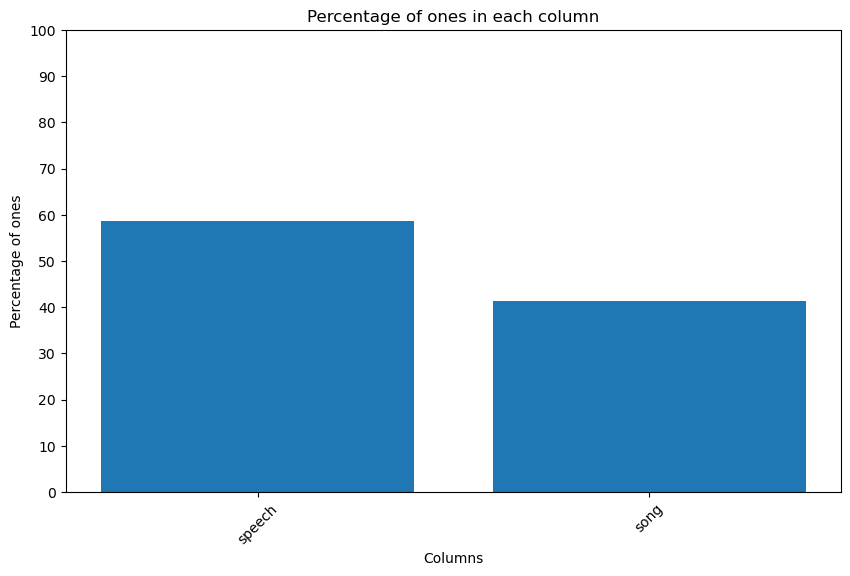

In [8]:
plot_percentage(df, values)

## Visualize the target class

In [9]:
TARGET_CLASS = 'song'

In [10]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler

def isomap_by_class(data, values_list, value):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    isomap = Isomap(n_components=2)
    embedding = isomap.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=data[value], cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {value} attribute using Isomap')
    plt.show()

In [11]:
from sklearn.decomposition import PCA

def pca_by_class(data, values_list, value):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    pca = PCA(n_components=2)
    embedding = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=data[value], cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {value} attribute using PCA')
    plt.show()

In [12]:
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

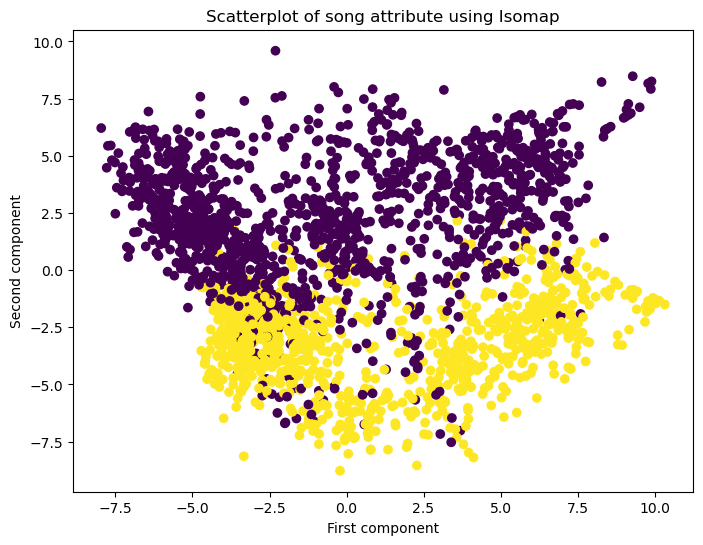

In [13]:
isomap_by_class(df[numerical_attr_list], values, TARGET_CLASS)

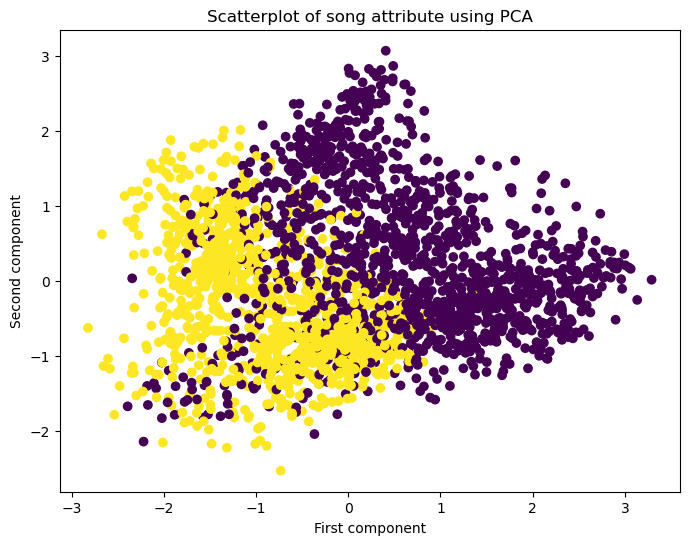

In [14]:
pca_by_class(df[numerical_attr_list], values, TARGET_CLASS)

## Dataset imbalance

In [15]:
from sklearn.model_selection import train_test_split

split_index = df.index[df['actor'] == 'actor_19'][0]

df_train = df[:split_index]
df_test = df[split_index:]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 100)




In [16]:
target_class_count_t = df_train[TARGET_CLASS].sum()
target_class_count_v = df_valid[TARGET_CLASS].sum()
other_class_count_t = df_train.shape[0] - target_class_count_t
other_class_count_v = df_valid.shape[0] - target_class_count_v
eight_percent_t = int(other_class_count_t * 8 / 100)
eight_percent_v = int(other_class_count_v * 8 / 100)

# target class is 8% the size of the other one
rows_to_keep_t = np.random.choice(df_train[df_train[TARGET_CLASS] == 1].index, eight_percent_t, replace=False)
rows_to_keep_v = np.random.choice(df_valid[df_valid[TARGET_CLASS] == 1].index, eight_percent_v, replace=False)
df_train = df_train[(df_train[TARGET_CLASS] == 1 & df_train.index.isin(rows_to_keep_t)) | (df_train[TARGET_CLASS] == 0)]
df_valid = df_valid[(df_valid[TARGET_CLASS] == 1 & df_valid.index.isin(rows_to_keep_v)) | (df_valid[TARGET_CLASS] == 0)]

df_valid = df_valid.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

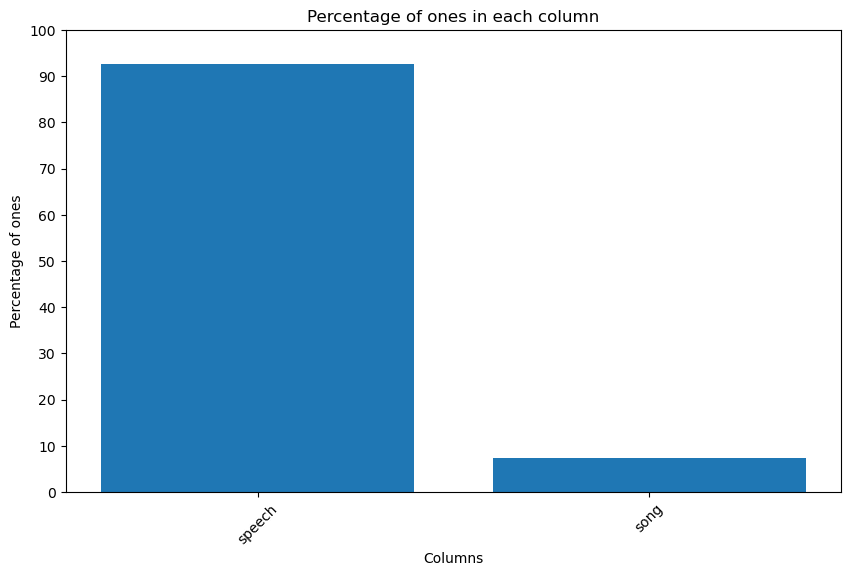

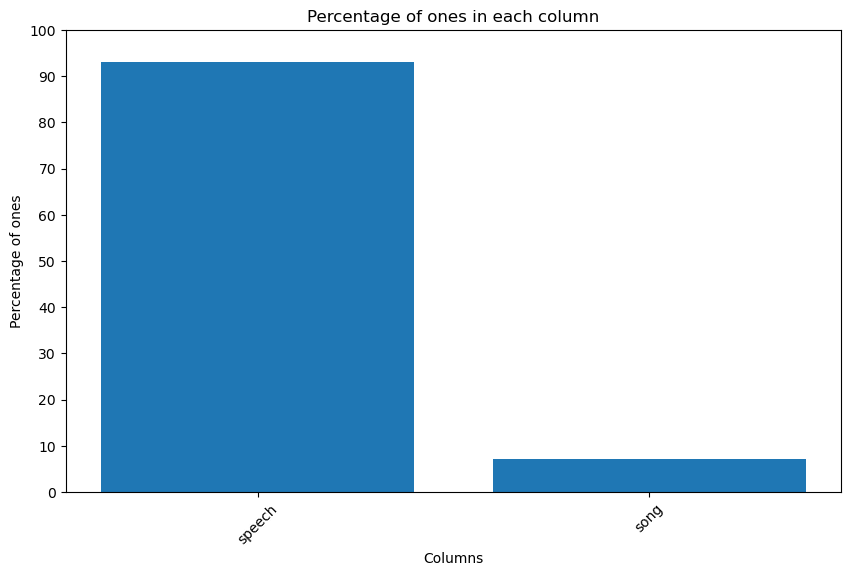

In [17]:
plot_percentage(df_train, values)
plot_percentage(df_valid, values)

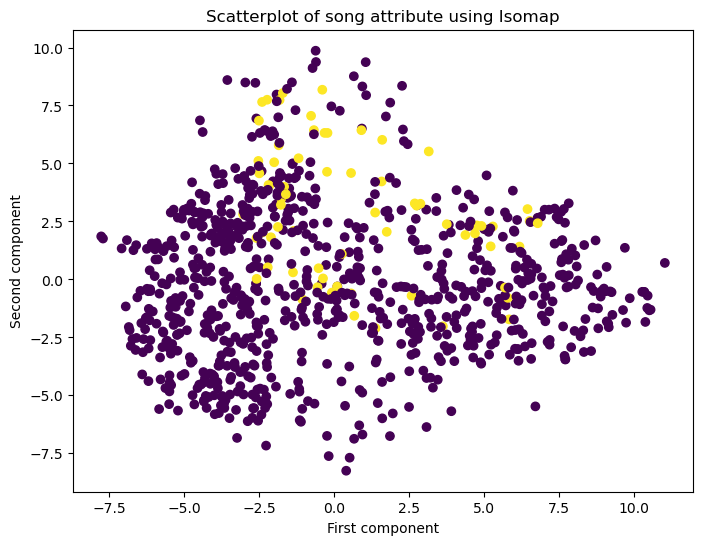

In [18]:
isomap_by_class(df_train[numerical_attr_list], values, TARGET_CLASS)

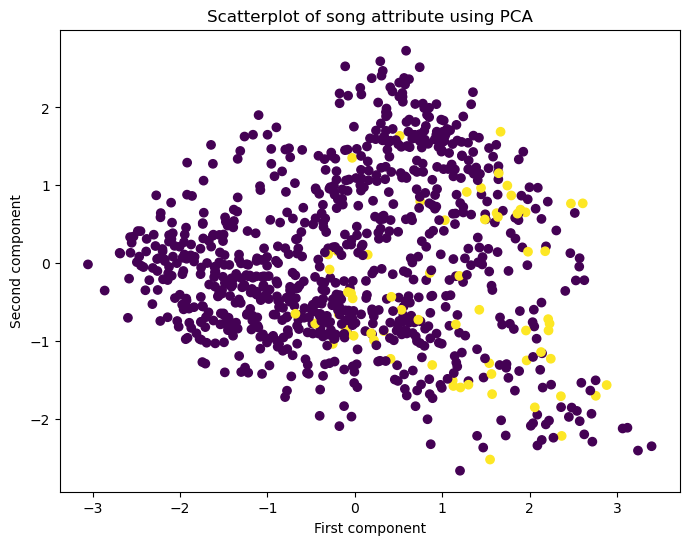

In [19]:
pca_by_class(df_train[numerical_attr_list], values, TARGET_CLASS)

# Dataset preparation

In [20]:
target_train = df_train[TARGET_CLASS]
target_valid = df_valid[TARGET_CLASS]
target_test = df_test[TARGET_CLASS]

display(df_train.shape, df_valid.shape, df_test.shape)

(914, 251)

(241, 251)

(617, 251)

In [21]:
excluded_prefixes = ['zc']
columns_to_keep = []

for column in df[numerical_attr_list].drop(values, axis=1).columns:
    if not column.startswith(tuple(excluded_prefixes)) and column != TARGET_COLUMN:
        columns_to_keep.append(column)

# selected features without target
columns_to_keep

['frame_count',
 'sum',
 'mean',
 'std',
 'min',
 'max',
 'q01',
 'q05',
 'q25',
 'q75',
 'q95',
 'q99',
 'kur',
 'skew',
 'lag1_q25',
 'lag1_q75',
 'lag1_skew',
 'mfcc_sum',
 'mfcc_mean',
 'mfcc_std',
 'mfcc_min',
 'mfcc_max',
 'mfcc_q01',
 'mfcc_q05',
 'mfcc_q25',
 'mfcc_q50',
 'mfcc_q75',
 'mfcc_q95',
 'mfcc_q99',
 'mfcc_kur',
 'mfcc_skew',
 'sc_sum',
 'sc_mean',
 'sc_std',
 'sc_min',
 'sc_max',
 'sc_q01',
 'sc_q05',
 'sc_q25',
 'sc_q50',
 'sc_q75',
 'sc_q95',
 'sc_q99',
 'sc_kur',
 'sc_skew',
 'stft_sum',
 'stft_mean',
 'stft_std',
 'stft_min',
 'stft_q01',
 'stft_q05',
 'stft_q25',
 'stft_q50',
 'stft_q75',
 'stft_kur',
 'stft_skew',
 'length_w1',
 'sum_w1',
 'std_w1',
 'q05_w1',
 'kur_w1',
 'skew_w1',
 'lag1_sum_w1',
 'lag1_max_w1',
 'lag1_q95_w1',
 'lag1_kur_w1',
 'lag1_skew_w1',
 'mfcc_sum_w1',
 'mfcc_mean_w1',
 'mfcc_std_w1',
 'mfcc_min_w1',
 'mfcc_max_w1',
 'mfcc_q05_w1',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'mfcc_q75_w1',
 'mfcc_q95_w1',
 'mfcc_q99_w1',
 'mfcc_kur_w1',
 'mfcc_sk

In [22]:
df_train = df_train.drop(df_train.columns.difference(columns_to_keep), axis=1)
df_valid = df_valid.drop(df_valid.columns.difference(columns_to_keep), axis=1)
df_test = df_test.drop(df_test.columns.difference(columns_to_keep), axis=1)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [23]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train)
X_valid = scaler.fit_transform(df_valid)
X_test = scaler.fit_transform(df_test)

y_train = target_train.to_numpy()
y_valid = target_valid.to_numpy()
y_test = target_test.to_numpy()

# Undersampling
## CNN

In [24]:
from collections import Counter
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42, n_jobs=-1)

X_res_t, y_res_t = cnn.fit_resample(X_train, y_train)
X_res_v, y_res_v = cnn.fit_resample(X_valid, y_valid)

print(f'Starting dataset shape: train {Counter(y_train)}   validation {Counter(y_valid)}')
print(f'Resampled dataset shape: train {Counter(y_res_t)}   validation {Counter(y_res_v)}')

Starting dataset shape: train Counter({0: 847, 1: 67})   validation Counter({0: 224, 1: 17})
Resampled dataset shape: train Counter({1: 67, 0: 64})   validation Counter({0: 22, 1: 17})


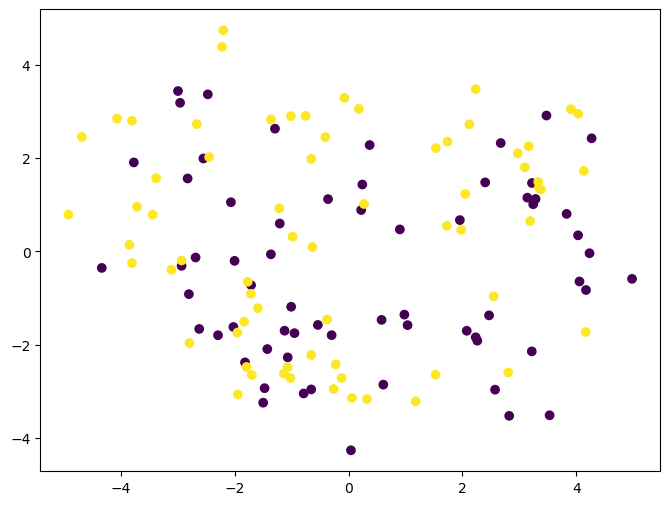

In [25]:
isomap = Isomap(n_components=2, n_neighbors=10)
embedding = isomap.fit_transform(X_res_t)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_res_t, cmap='viridis')
plt.show()

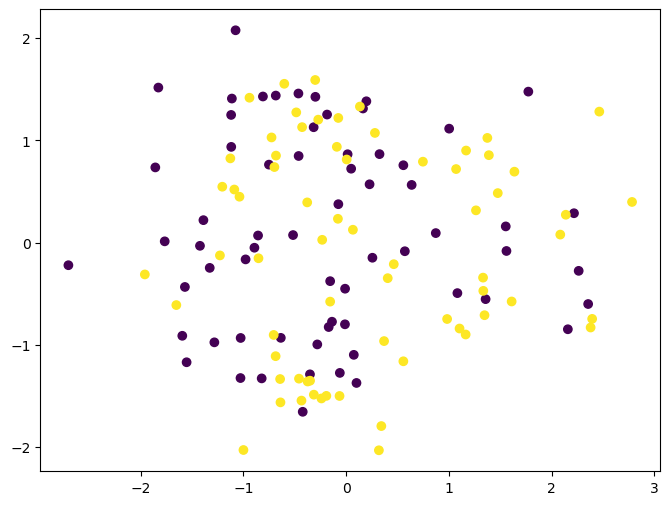

In [26]:
pca = PCA(n_components=2)
embedding = pca.fit_transform(X_res_t)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_res_t, cmap='viridis')
plt.show()

# Logistic Regression

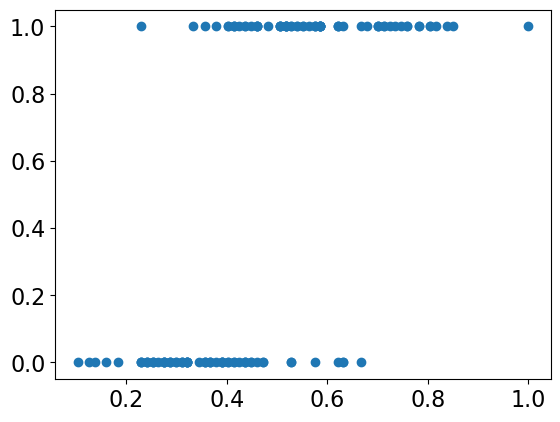

In [27]:
plt.scatter(X_res_t.T[0], y_res_t)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])
    

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_res_t, y_res_t)
    y_pred = logr.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-13 15:00:54,103] A new study created in memory with name: no-name-2a7898a6-3bed-43e2-b46e-29eaa143f03b
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[W 2023-06-13 15:00:54,103] Trial 2 failed with parameters: {'penalty': 'elasticnet', 'C': 5.323637832177275, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalt

[W 2023-06-13 15:00:54,176] Trial 10 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2023-06-13 15:00:54,193] Trial 3 finished with value: 0.9487179487179487 and parameters: {'penalty': 'l2', 'C': 7.7493844395979234, 'solver': 'saga'}. Best is trial 5 with value: 0.9487179487179487.
[W 2023-06-13 15:00:54,197] Trial 13 failed with value None.
[I 2023-06-13 15:00:54,201] Trial 6 finished with value: 0.9487179487179487 and parameters: {'penalty': 'none', 'C': 0.8876126194366825, 'solver': 'saga'}. Best i

[W 2023-06-13 15:00:54,255] Trial 14 failed with value None.
[W 2023-06-13 15:00:54,296] Trial 23 failed with value None.
[W 2023-06-13 15:00:54,296] Trial 24 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-13 15:00:54,308] Trial 26 finished with value: 0.9487179487179487 and parameters: {'penalty': 'l2', 'C': 7.62125972635064, 'solver': 'liblinear'}. Best is trial 5 with value: 0.9487179487179487.
[I 2023-06-13 15:00:54,312] Trial 20 finished with value: 0.9487179487179487 and parameters: {'penalty': 'l2', 'C': 4.977763810507682, 'solver': 'sag'}. Best is trial 5 with value: 0.9487179487179487.
[I 2023-06-13 15:00:54,322] Trial 27 finished with value: 0.6153846153846154 and parameters: {'penalty': 'l1', 'C': 7.689997057927029, 'solver': 'liblinear'}. Best is trial 5 with value: 0.9487179487179487.
C:\Users\emanu\anaconda3\

[W 2023-06-13 15:00:54,383] Trial 30 failed with value None.
[W 2023-06-13 15:00:54,383] Trial 31 failed with value None.
[I 2023-06-13 15:00:54,383] Trial 1 finished with value: 0.9487179487179487 and parameters: {'penalty': 'l2', 'C': 8.145572272283076, 'solver': 'newton-cg'}. Best is trial 5 with value: 0.9487179487179487.
[W 2023-06-13 15:00:54,383] Trial 32 failed with value None.
[W 2023-06-13 15:00:54,383] Trial 33 failed with value None.
[W 2023-06-13 15:00:54,383] Trial 34 failed with value None.
[W 2023-06-13 15:00:54,398] Trial 36 failed with parameters: {'penalty': 'elasticnet', 'C': 9.301741905451895, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_293

[W 2023-06-13 15:00:54,445] Trial 38 failed with value None.
[W 2023-06-13 15:00:54,445] Trial 40 failed with value None.
[W 2023-06-13 15:00:54,461] Trial 39 failed with value None.
[W 2023-06-13 15:00:54,461] Trial 42 failed with value None.
[W 2023-06-13 15:00:54,461] Trial 41 failed with value None.
[W 2023-06-13 15:00:54,461] Trial 44 failed with parameters: {'penalty': 'elasticnet', 'C': 9.688703992262521, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solve

[W 2023-06-13 15:00:54,527] Trial 47 failed with value None.
[W 2023-06-13 15:00:54,527] Trial 46 failed with value None.
[W 2023-06-13 15:00:54,527] Trial 48 failed with value None.
[W 2023-06-13 15:00:54,527] Trial 50 failed with value None.
[W 2023-06-13 15:00:54,527] Trial 49 failed with value None.
[W 2023-06-13 15:00:54,543] Trial 52 failed with parameters: {'penalty': 'elasticnet', 'C': 9.940405554636968, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solve

[W 2023-06-13 15:00:54,621] Trial 59 failed with value None.
[W 2023-06-13 15:00:54,606] Trial 56 failed with value None.
[W 2023-06-13 15:00:54,606] Trial 55 failed with value None.
[W 2023-06-13 15:00:54,606] Trial 57 failed with value None.
[W 2023-06-13 15:00:54,606] Trial 60 failed with parameters: {'penalty': 'elasticnet', 'C': 9.634819675945366, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\eman

[W 2023-06-13 15:00:54,684] Trial 66 failed with value None.
[W 2023-06-13 15:00:54,700] Trial 69 failed with parameters: {'penalty': 'elasticnet', 'C': 9.759752603822253, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties,

[W 2023-06-13 15:00:54,779] Trial 78 failed with parameters: {'penalty': 'elasticnet', 'C': 9.735926083498807, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-13 15:00:54,779] Trial 77

[W 2023-06-13 15:00:54,842] Trial 81 failed with value None.
[W 2023-06-13 15:00:54,858] Trial 85 failed with parameters: {'penalty': 'elasticnet', 'C': 9.80497393919862, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, 

[W 2023-06-13 15:00:54,931] Trial 94 failed with parameters: {'penalty': 'elasticnet', 'C': 9.995735649441613, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-13 15:00:54,931] Trial 90

[W 2023-06-13 15:00:54,997] Trial 101 failed with parameters: {'penalty': 'elasticnet', 'C': 9.405454427415593, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-13 15:00:54,997] Trial 9

[W 2023-06-13 15:00:55,059] Trial 109 failed with parameters: {'penalty': 'elasticnet', 'C': 9.211561128680664, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-13 15:00:55,075] Trial 1

[W 2023-06-13 15:00:55,133] Trial 117 failed with parameters: {'penalty': 'elasticnet', 'C': 9.321693163803998, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-13 15:00:55,149] Trial 1

[W 2023-06-13 15:00:55,211] Trial 124 failed with parameters: {'penalty': 'elasticnet', 'C': 9.939067829036325, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-13 15:00:55,211] Trial 1

[W 2023-06-13 15:00:55,274] Trial 133 failed with parameters: {'penalty': 'elasticnet', 'C': 9.947359281130913, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-13 15:00:55,289] Trial 1

[W 2023-06-13 15:00:55,355] Trial 141 failed with parameters: {'penalty': 'elasticnet', 'C': 9.715502885403142, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-13 15:00:55,355] Trial 1

[W 2023-06-13 15:00:55,422] Trial 149 failed with parameters: {'penalty': 'elasticnet', 'C': 9.70885170522349, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3441430082.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
[W 2023-06-13 15:00:55,422] Trial 14

In [30]:
best_params = study.best_params

logr = LogisticRegression(**best_params)
logr.fit(X_res_t.T[0].reshape(-1,1), y_res_t)

y_pred_test = logr.predict(X_test.T[0].reshape(-1,1))


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 6.892073867095342, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       355
           1       0.90      0.92      0.91       262

    accuracy                           0.92       617
   macro avg       0.92      0.92      0.92       617
weighted avg       0.92      0.92      0.92       617

Accuracy 0.9222042139384117
F1-score [0.93162393 0.90977444]


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

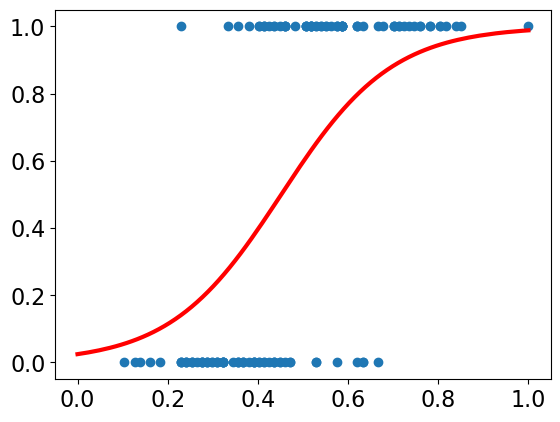

In [31]:
from scipy.special import expit

loss = expit(sorted(X_test.T[0].reshape(-1,1)) *logr.coef_.T[0] + logr.intercept_).ravel()
plt.plot(sorted(X_test.T[0].reshape(-1,1)), loss, color='red', linewidth=3)
plt.scatter(X_res_t.T[0].reshape(-1,1), y_res_t)
#plt.xlabel(selected_columns[0], fontsize=16)
#plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

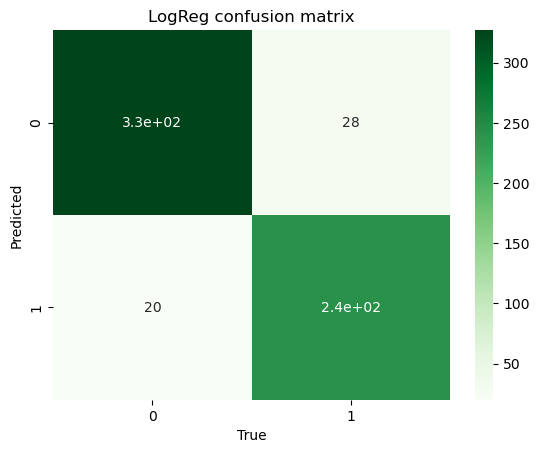

In [32]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LogReg confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'LogReg_conf_matrix.pdf'), format='pdf')
plt.show()

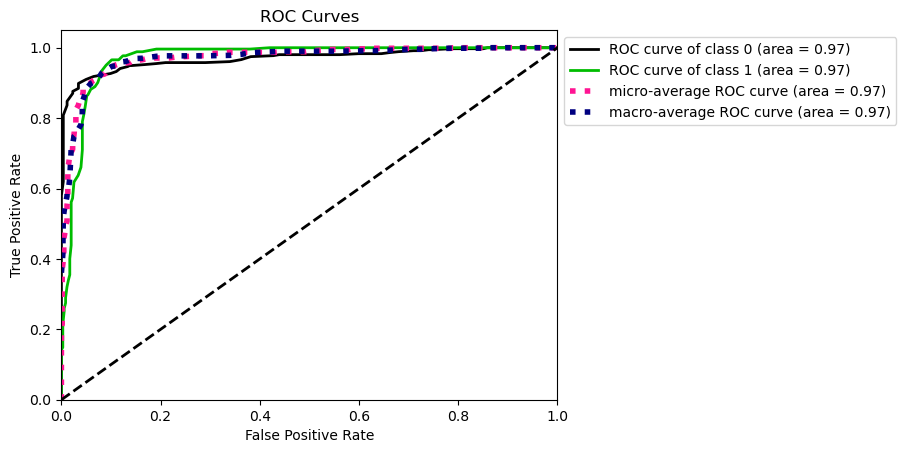

0.9694925276851951


In [33]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = logr.predict_proba(X_test.T[0].reshape(-1,1))
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'LogReg_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

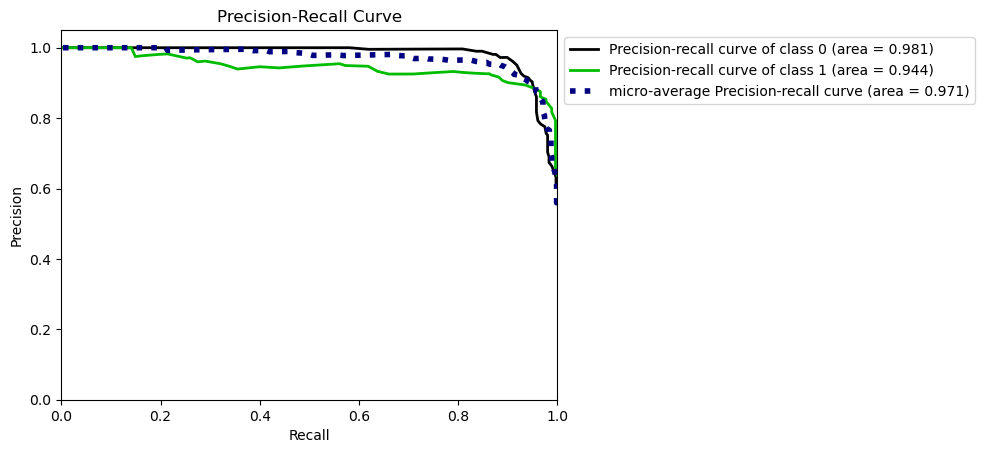

In [34]:
from scikitplot.metrics import plot_precision_recall

plot_precision_recall(y_test, logr.predict_proba(X_test.T[0].reshape(-1,1)))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# Suppport Vector Machine

In [35]:
pca = PCA(n_components=2)
pca.fit(X_res_t)
X_pca = pca.transform(X_res_t)

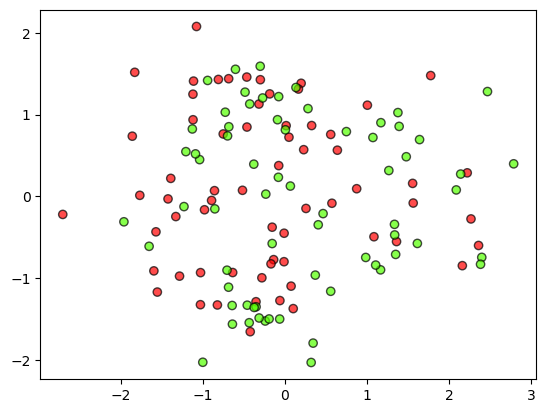

In [36]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

## Linear SVM

In [37]:
from sklearn.svm import LinearSVC

In [38]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    

    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-13 15:00:56,371] A new study created in memory with name: no-name-ccde347c-7458-4e6f-8a2e-829d5e60d9d2
[W 2023-06-13 15:00:56,371] Trial 0 failed with parameters: {'penalty': 'l1', 'C': 0.8589722149154982, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base

[W 2023-06-13 15:00:56,420] Trial 7 failed with value None.
[W 2023-06-13 15:00:56,429] Trial 12 failed with parameters: {'penalty': 'l1', 'C': 32.64033181111408, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _

[I 2023-06-13 15:00:56,456] Trial 11 finished with value: 0.9230769230769231 and parameters: {'penalty': 'l2', 'C': 68.98722710586127, 'loss': 'squared_hinge'}. Best is trial 2 with value: 0.9230769230769231.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-06-13 15:00:56,459] Trial 20 failed with parameters: {'penalty': 'l1', 'C': 66.99553437603059, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objecti

[W 2023-06-13 15:00:56,494] Trial 26 failed with value None.
[I 2023-06-13 15:00:56,495] Trial 22 finished with value: 0.9230769230769231 and parameters: {'penalty': 'l2', 'C': 59.36366114562469, 'loss': 'hinge'}. Best is trial 19 with value: 0.9487179487179487.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-06-13 15:00:56,500] Trial 28 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2023-06-13 15:00:56,501] Trial 29 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear

[W 2023-06-13 15:00:56,571] Trial 31 failed with value None.
[W 2023-06-13 15:00:56,571] Trial 36 failed with parameters: {'penalty': 'l1', 'C': 39.40350818800645, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = 

[W 2023-06-13 15:00:56,633] Trial 42 failed with parameters: {'penalty': 'l1', 'C': 40.20094441884267, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)


[W 2023-06-13 15:00:56,672] Trial 44 failed with value None.
[W 2023-06-13 15:00:56,673] Trial 45 failed with value None.
[W 2023-06-13 15:00:56,677] Trial 48 failed with parameters: {'penalty': 'l1', 'C': 38.37858107407715, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\s

[W 2023-06-13 15:00:56,736] Trial 54 failed with parameters: {'penalty': 'l1', 'C': 38.56689943743758, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)


[W 2023-06-13 15:00:56,791] Trial 56 failed with value None.
[W 2023-06-13 15:00:56,791] Trial 59 failed with parameters: {'penalty': 'l1', 'C': 38.249175525678204, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type =

[W 2023-06-13 15:00:56,841] Trial 62 failed with value None.
[W 2023-06-13 15:00:56,843] Trial 63 failed with value None.
[W 2023-06-13 15:00:56,856] Trial 66 failed with parameters: {'penalty': 'l1', 'C': 38.84169153958558, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\s

[W 2023-06-13 15:00:56,892] Trial 66 failed with value None.
[W 2023-06-13 15:00:56,893] Trial 67 failed with value None.
[W 2023-06-13 15:00:56,894] Trial 68 failed with value None.
[W 2023-06-13 15:00:56,905] Trial 72 failed with parameters: {'penalty': 'l1', 'C': 34.5327469017715, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(


[W 2023-06-13 15:00:56,966] Trial 79 failed with parameters: {'penalty': 'l1', 'C': 39.34299592312618, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)


[W 2023-06-13 15:00:57,004] Trial 80 failed with value None.
[W 2023-06-13 15:00:57,006] Trial 75 failed with value None.
[W 2023-06-13 15:00:57,007] Trial 81 failed with value None.
[W 2023-06-13 15:00:57,016] Trial 84 failed with parameters: {'penalty': 'l1', 'C': 39.83028630373132, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(

[W 2023-06-13 15:00:57,060] Trial 84 failed with value None.
[W 2023-06-13 15:00:57,069] Trial 90 failed with parameters: {'penalty': 'l1', 'C': 37.99300928210551, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = 

[W 2023-06-13 15:00:57,124] Trial 96 failed with parameters: {'penalty': 'l1', 'C': 35.714658970919, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  

[W 2023-06-13 15:00:57,180] Trial 102 failed with parameters: {'penalty': 'l1', 'C': 36.848084211866016, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual

[W 2023-06-13 15:00:57,225] Trial 103 failed with value None.
[W 2023-06-13 15:00:57,235] Trial 108 failed with parameters: {'penalty': 'l1', 'C': 41.37336147269659, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type 

[W 2023-06-13 15:00:57,291] Trial 112 failed with parameters: {'penalty': 'l1', 'C': 35.72673672947962, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)

[W 2023-06-13 15:00:57,337] Trial 116 failed with value None.
[W 2023-06-13 15:00:57,343] Trial 120 failed with parameters: {'penalty': 'l1', 'C': 40.39680978050025, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type 

[W 2023-06-13 15:00:57,391] Trial 122 failed with value None.
[W 2023-06-13 15:00:57,399] Trial 126 failed with parameters: {'penalty': 'l1', 'C': 36.7004965521332, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type =

[W 2023-06-13 15:00:57,444] Trial 127 failed with value None.
[W 2023-06-13 15:00:57,451] Trial 132 failed with parameters: {'penalty': 'l1', 'C': 38.009258658770065, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type

[W 2023-06-13 15:00:57,493] Trial 133 failed with value None.
[W 2023-06-13 15:00:57,504] Trial 138 failed with parameters: {'penalty': 'l1', 'C': 40.20060793611175, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type 

[W 2023-06-13 15:00:57,558] Trial 144 failed with parameters: {'penalty': 'l1', 'C': 38.74605429522206, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)

[W 2023-06-13 15:00:57,609] Trial 146 failed with value None.
[W 2023-06-13 15:00:57,611] Trial 147 failed with value None.
[W 2023-06-13 15:00:57,611] Trial 148 failed with value None.
[W 2023-06-13 15:00:57,611] Trial 149 failed with value None.


In [39]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(X_res_t, y_res_t)

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'penalty': 'l2', 'C': 1.869914370628507, 'loss': 'squared_hinge'}
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       355
           1       0.98      0.77      0.86       262

    accuracy                           0.90       617
   macro avg       0.92      0.88      0.89       617
weighted avg       0.91      0.90      0.89       617

Accuracy 0.8962722852512156
F1-score [0.91644909 0.86324786]


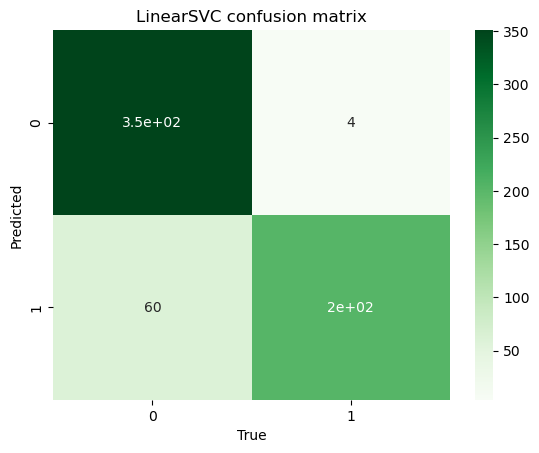

In [40]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'LinearSVC_conf_matrix.pdf'), format='pdf')
plt.show()

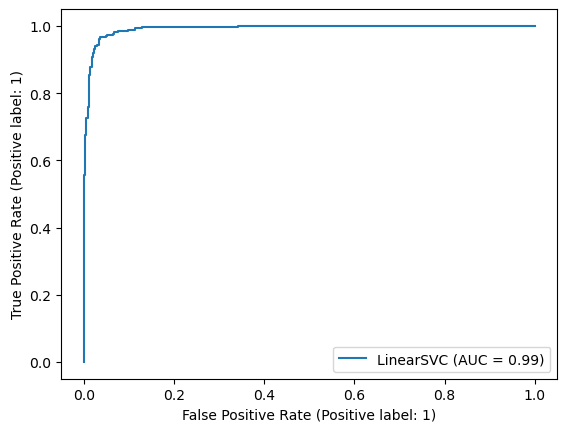

In [41]:
from sklearn.metrics import RocCurveDisplay

linear_svc_disp = RocCurveDisplay.from_estimator(lin_svc, X_test, y_test)
plt.savefig(os.path.join(IMAGE_FOLDER, 'LinearSVC_ROC.pdf'), format='pdf')

In [42]:
decision_function = lin_svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [43]:
support_vectors_pca = pca.transform(support_vectors)

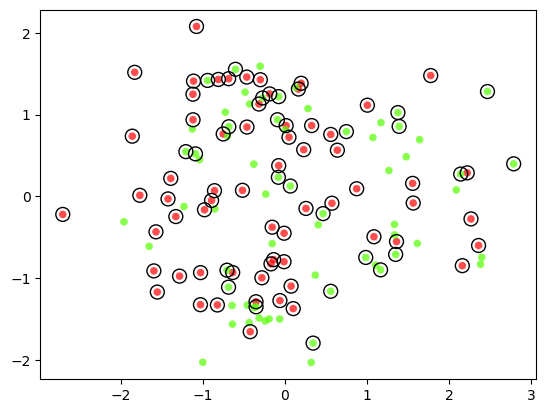

In [44]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


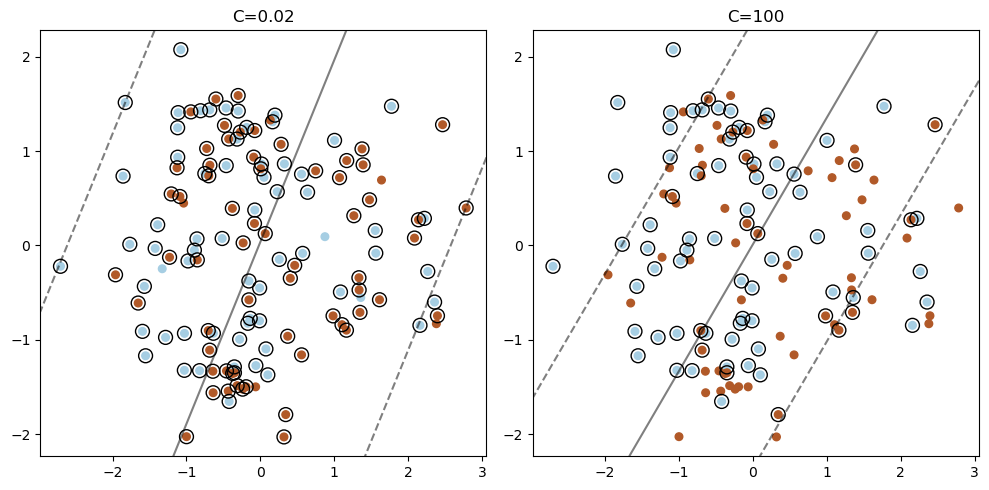

In [45]:
plt.figure(figsize=(10, 5))
for i, C in enumerate([0.02, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="squared_hinge", penalty='l2', random_state=42).fit(X_res_t, y_res_t)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X_res_t)
#     we can also calculate the decision function manually
#     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
    support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
    support_vectors = X_res_t[support_vector_indices]
    support_vectors_pca = pca.transform(support_vectors)

    plt.subplot(1, 2, i + 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
    #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_FOLDER, f'LinearSVC_C_{C}.pdf'), format='pdf')
plt.show()

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [46]:
from sklearn.svm import SVC

In [47]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.01,100)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    

    lin_svc = SVC(kernel=kernel, gamma=gamma, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-13 15:00:58,402] A new study created in memory with name: no-name-2dc7312d-5e84-4768-9631-b7691788ab70
[I 2023-06-13 15:00:58,410] Trial 0 finished with value: 0.8717948717948718 and parameters: {'kernel': 'rbf', 'C': 45.34052669842624, 'gamma': 0.33955642539399394}. Best is trial 0 with value: 0.8717948717948718.
[I 2023-06-13 15:00:58,417] Trial 1 finished with value: 0.8461538461538461 and parameters: {'kernel': 'rbf', 'C': 5.3625863635179325, 'gamma': 0.46114360268969184}. Best is trial 0 with value: 0.8717948717948718.
[I 2023-06-13 15:00:58,417] Trial 2 finished with value: 0.4358974358974359 and parameters: {'kernel': 'sigmoid', 'C': 54.368180567366736, 'gamma': 0.9869121201068148}. Best is trial 0 with value: 0.8717948717948718.
[I 2023-06-13 15:00:58,417] Trial 3 finished with value: 0.4358974358974359 and parameters: {'kernel': 'sigmoid', 'C': 53.743270978338074, 'gamma': 0.9140828372091938}. Best is trial 0 with value: 0.8717948717948718.
[I 2023-06-13 15:00:58,41

[I 2023-06-13 15:00:58,903] Trial 38 finished with value: 0.4358974358974359 and parameters: {'kernel': 'sigmoid', 'C': 91.96627562830056, 'gamma': 0.1726136157827212}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:00:58,916] Trial 40 finished with value: 0.4358974358974359 and parameters: {'kernel': 'sigmoid', 'C': 91.46712964742895, 'gamma': 0.16607298702639747}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:00:58,940] Trial 39 finished with value: 0.4358974358974359 and parameters: {'kernel': 'sigmoid', 'C': 88.80715213832208, 'gamma': 0.20818560546767478}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:00:58,995] Trial 42 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 91.2046132670216, 'gamma': 0.20020623261769188}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:00:59,001] Trial 41 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 91.3453287058625

[I 2023-06-13 15:00:59,553] Trial 77 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 88.13661257585989, 'gamma': 0.6039283861932844}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:00:59,558] Trial 78 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 88.83440553398361, 'gamma': 0.5887121774300509}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:00:59,559] Trial 79 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 89.64030874351545, 'gamma': 0.5987786570163248}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:00:59,622] Trial 81 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 93.14546184785277, 'gamma': 0.5970122885077911}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:00:59,622] Trial 80 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 88.19994357744307, 'gamma':

[I 2023-06-13 15:01:00,157] Trial 116 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 95.42318531619775, 'gamma': 0.41431369484142844}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:01:00,169] Trial 117 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 83.31046936382585, 'gamma': 0.1270962035816231}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:01:00,200] Trial 118 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 95.14376128141924, 'gamma': 0.13101106704126286}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:01:00,223] Trial 119 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 83.34749161211118, 'gamma': 0.413326193597937}. Best is trial 8 with value: 0.9487179487179487.
[I 2023-06-13 15:01:00,256] Trial 121 finished with value: 0.9487179487179487 and parameters: {'kernel': 'poly', 'C': 83.91161326822474, 'g

In [48]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(X_res_t, y_res_t)

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'poly', 'C': 63.79228680519603, 'gamma': 0.9898475264620172}
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       355
           1       0.97      0.77      0.86       262

    accuracy                           0.89       617
   macro avg       0.91      0.88      0.88       617
weighted avg       0.90      0.89      0.89       617

Accuracy 0.8914100486223663
F1-score [0.9124183  0.85714286]


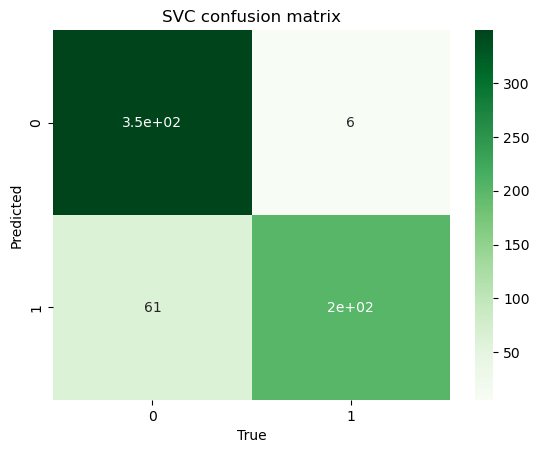

In [52]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('SVC confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'SVC_conf_matrix.pdf'), format='pdf')
plt.show()

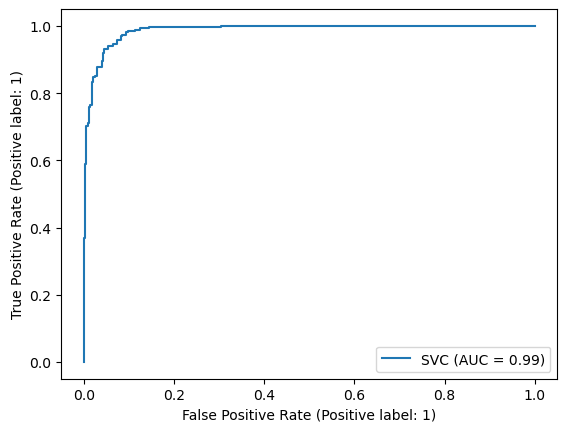

In [53]:
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)
plt.savefig(os.path.join(IMAGE_FOLDER, 'SVC_ROC.pdf'), format='pdf')

In [54]:
support_vectors_pca = pca.transform(svc.support_vectors_)

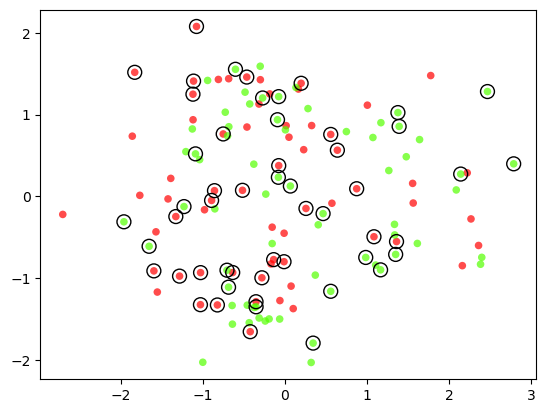

In [55]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [56]:
decision_function = svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [57]:
support_vectors_pca = pca.transform(support_vectors)

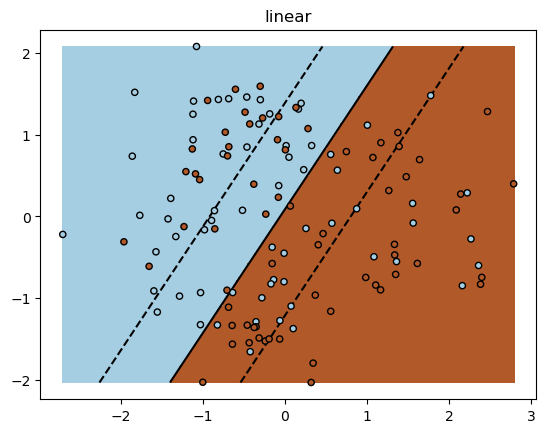

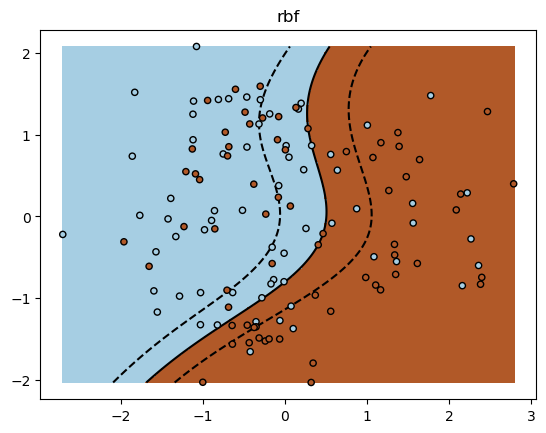

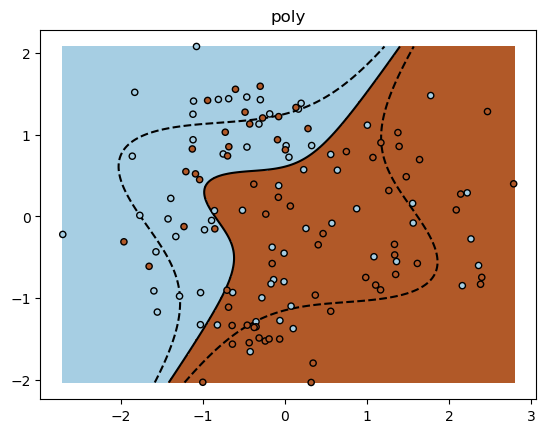

In [58]:
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=0.1, C=26)
    clf.fit(X_res_t, y_res_t)

    plt.figure()
    plt.clf()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
#     plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=80, facecolors='none',
#                 zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X_pca[:, 0].min()
    x_max = X_pca[:, 0].max()
    y_min = X_pca[:, 1].min()
    y_max = X_pca[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    clf.fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
    plt.savefig(os.path.join(IMAGE_FOLDER, f'SVC_kernel_{kernel}.pdf'), format='pdf')
plt.show()

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [59]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

In [60]:
from scikeras.wrappers import KerasClassifier

In [61]:
from sklearn.model_selection import RandomizedSearchCV

In [62]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(n_classes_, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [63]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [64]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    net.fit(X_res_t, y_res_t, epochs=50)
    y_pred = net.predict(X_res_v).astype(int)
#     print(y_pred.shape, y_res_v.shape)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-06-13 15:04:17,010] A new study created in memory with name: no-name-5e74233b-abe8-4ab2-8c97-f36380f9c4c7
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
5/5 [==============================] - 4s 29ms/step - loss: 0.6996 - accuracy: 0.5115
Epoch 2/50
5/5 [==============================] - 4s 33ms/step - loss: 0.6962 - accuracy: 0.4962
Epoch 2/50
5/5 [==============================] - 4s 26ms/step - loss: 0.7153 - accuracy: 0.5115
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 0.6886 - accuracy: 0.5191
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6632 - accuracy: 0.6250Epoch 3/50
Epoch 3/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6662 - accuracy: 0.6870
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6759 - accuracy: 0.5938Epoch 4/50
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6591 - accuracy: 0.7634
Epoch 5/50
Epoch 5/50
Epoch 5/50
5/5 [==============================] - 0s 15ms/step - loss: 0.7038 - accuracy: 0.5115
Epoch 5/50
5/5 [==

5/5 [==============================] - 0s 7ms/step - loss: 0.5319 - accuracy: 0.8321
Epoch 19/50
3/5 [=================>............] - ETA: 0s - loss: 0.5290 - accuracy: 0.8021Epoch 19/50
Epoch 18/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6941 - accuracy: 0.5115
Epoch 20/50
Epoch 19/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6970 - accuracy: 0.4580
Epoch 20/50
5/5 [==============================] - 0s 10ms/step - loss: 0.5930 - accuracy: 0.8626
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5884 - accuracy: 0.7812Epoch 20/50
Epoch 21/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6943 - accuracy: 0.5115
Epoch 21/50
5/5 [==============================] - 6s 21ms/step - loss: 0.6931 - accuracy: 0.4656
Epoch 22/50
Epoch 2/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6948 - accuracy: 0.5115
Epoch 22/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6952 - accuracy: 0.5115

5/5 [==============================] - 0s 12ms/step - loss: 0.6708 - accuracy: 0.5115
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7294 - accuracy: 0.4688Epoch 9/50
Epoch 27/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6950 - accuracy: 0.5115
Epoch 8/50
5/5 [==============================] - 0s 10ms/step - loss: 0.6941 - accuracy: 0.5115
Epoch 6/50
Epoch 30/50
Epoch 28/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6666 - accuracy: 0.6565
Epoch 28/50
5/5 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.5115
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5546 - accuracy: 0.8125Epoch 29/50
Epoch 31/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6558 - accuracy: 0.6947
Epoch 10/50
5/5 [==============================] - 0s 8ms/step - loss: 0.5382 - accuracy: 0.8397
Epoch 8/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6937 - accuracy: 0.5115
Epoc

5/5 [==============================] - 0s 10ms/step - loss: 0.2761 - accuracy: 0.9160
Epoch 14/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2677 - accuracy: 0.9389
Epoch 16/50
Epoch 15/50
5/5 [==============================] - 0s 9ms/step - loss: 0.7030 - accuracy: 0.5115
Epoch 16/50
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6955 - accuracy: 0.5000Epoch 35/50
Epoch 38/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2529 - accuracy: 0.9389
Epoch 37/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2973 - accuracy: 0.8779
Epoch 37/50
Epoch 17/50
5/5 [==============================] - 0s 8ms/step - loss: 0.4926 - accuracy: 0.9084
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6865 - accuracy: 0.5625Epoch 16/50
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5295 - accuracy: 0.9375Epoch 39/50
Epoch 16/50
5/5 [==============================] - 0s 10ms/step - loss: 0.6961

5/5 [==============================] - 0s 12ms/step - loss: 0.6361 - accuracy: 0.9084
Epoch 46/50
Epoch 23/50
Epoch 22/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4861 - accuracy: 0.9008
Epoch 24/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1933 - accuracy: 0.9466
Epoch 44/50
5/5 [==============================] - 0s 8ms/step - loss: 0.4912 - accuracy: 0.8244
Epoch 45/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2979 - accuracy: 0.9008
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4236 - accuracy: 0.9375Epoch 24/50
Epoch 23/50
5/5 [==============================] - 0s 10ms/step - loss: 0.6958 - accuracy: 0.5115
Epoch 26/50
5/5 [==============================] - 0s 9ms/step - loss: 0.4314 - accuracy: 0.8931
Epoch 45/50
Epoch 25/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.4962
Epoch 45/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6197 - accuracy: 0.

2/2 [==============================] - 0s 4ms/step
Epoch 34/50
Epoch 35/50
Epoch 33/50
2/2 [==============================] - 0s 17ms/stepss: 0.1307 - accuracy: 0.9662
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3538 - accuracy: 0.9062

[I 2023-06-13 15:04:26,718] Trial 3 finished with value: 0.8717948717948718 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.8717948717948718.


5/5 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9313

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 12ms/step - loss: 0.4851 - accuracy: 0.8931
Epoch 34/50
5/5 [==============================] - 0s 17ms/step - loss: 0.3684 - accuracy: 0.8779
Epoch 35/50
Epoch 36/50
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.4739 - accuracy: 0.8931

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 24ms/step - loss: 0.4739 - accuracy: 0.8931
Epoch 36/50
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2451 - accuracy: 0.9375Epoch 35/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

1/5 [=====>........................] - ETA: 0s - loss: 0.3727 - accuracy: 0.9062

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 12ms/step - loss: 0.1420 - accuracy: 0.9542
Epoch 37/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4564 - accuracy: 0.9313
Epoch 38/50
Epoch 36/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4636 - accuracy: 0.8702
Epoch 38/50
5/5 [==============================] - 0s 17ms/step - loss: 0.3390 - accuracy: 0.9160
Epoch 37/50
Epoch 39/50
Epoch 38/50
5/5 [==============================] - 0s 22ms/step - loss: 0.4348 - accuracy: 0.9160
Epoch 39/50
Epoch 40/50
Epoch 38/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1285 - accuracy: 0.9618
Epoch 40/50
5/5 [==============================] - 0s 25ms/step - loss: 0.4138 - accuracy: 0.9160
Epoch 39/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1199 - accuracy: 0.9542
Epoch 1/50
Epoch 1/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4019 - accuracy: 0.9008
Epoch 41/50
5/5 [==============================] - 0s 34ms/s

2/2 [==============================] - 0s 31ms/step


[I 2023-06-13 15:04:29,434] Trial 2 finished with value: 0.8974358974358975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 2 with value: 0.8974358974358975.
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) whi

2/2 [==============================] - 0s 23ms/step


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

2/2 [==============================] - 0s 25ms/step


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 3s 14ms/step - loss: 0.6312 - accuracy: 0.7099
Epoch 2/50
Epoch 1/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6588 - accuracy: 0.5573
Epoch 3/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6130 - accuracy: 0.7099
Epoch 4/50
5/5 [==============================] - 0s 32ms/step - loss: 0.5978 - accuracy: 0.7481
Epoch 5/50
5/5 [==============================] - 0s 15ms/step - loss: 0.5922 - accuracy: 0.7634
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5798 - accuracy: 0.7176
Epoch 7/50
5/5 [==============================] - 0s 20ms/step - loss: 0.5618 - accuracy: 0.8321
Epoch 8/50
5/5 [==============================] - 0s 25ms/step - loss: 0.5586 - accuracy: 0.7252
Epoch 9/50
5/5 [==============================] - 0s 33ms/step - loss: 0.5462 - accuracy: 0.7786
Epoch 10/50
5/5 [==============================] - 0s 23ms/step - loss: 0.5271 - accuracy: 0.8015
Epoch 11/50
5/5 [============

5/5 [==============================] - 0s 15ms/step - loss: 0.7016 - accuracy: 0.4885
Epoch 21/50
Epoch 32/50
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 0.7070 - accuracy: 0.4885
Epoch 5/50
Epoch 22/50
Epoch 9/50
5/5 [==============================] - 0s 8ms/step - loss: 0.5389 - accuracy: 0.8092
Epoch 34/50
5/5 [==============================] - 0s 14ms/step - loss: 0.3804 - accuracy: 0.8702
Epoch 14/50
Epoch 10/50
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4525 - accuracy: 0.9062Epoch 23/50
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 0.3609 - accuracy: 0.8626
Epoch 11/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6988 - accuracy: 0.4885
Epoch 35/50
Epoch 7/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3378 - accuracy: 0.8931
Epoch 12/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4088 - accuracy: 0.9084
Epoch 36/50
5/5 [==============================

5/5 [==============================] - 0s 9ms/step - loss: 0.3326 - accuracy: 0.9160
Epoch 44/50
5/5 [==============================] - 0s 9ms/step - loss: 0.4405 - accuracy: 0.8702
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3418 - accuracy: 0.9062Epoch 20/50
Epoch 14/50
Epoch 23/50
Epoch 15/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.4198
Epoch 45/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4194 - accuracy: 0.9237
Epoch 24/50
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3178 - accuracy: 0.9062Epoch 33/50
Epoch 15/50
Epoch 21/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3028 - accuracy: 0.9389
Epoch 46/50
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5724 - accuracy: 0.6562Epoch 16/50
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3170 - accuracy: 0.9375Epoch 17/50
Epoch 34/50
5/5 [==============================] - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1667 - accuracy: 0.9389
Epoch 30/50
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6639 - accuracy: 0.5312Epoch 34/50
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.5115Epoch 26/50
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1717 - accuracy: 0.9375Epoch 35/50
Epoch 43/50
5/5 [==============================] - 0s 13ms/step - loss: 0.8290 - accuracy: 0.4885
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7174 - accuracy: 0.4062Epoch 7/50
Epoch 5/50
5/5 [==============================] - 0s 10ms/step - loss: 0.6975 - accuracy: 0.5115
Epoch 27/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2492 - accuracy: 0.9313
Epoch 32/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6586 - accuracy: 0.5649
Epoch 36/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6955 - accuracy: 0.5115


[I 2023-06-13 15:04:35,678] Trial 8 finished with value: 0.8717948717948718 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 15ms/step - loss: 0.8055 - accuracy: 0.4885
Epoch 6/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2778 - accuracy: 0.9008
Epoch 33/50
Epoch 28/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6962 - accuracy: 0.5115
Epoch 37/50
4/5 [=======================>......] - ETA: 0s - loss: 0.7000 - accuracy: 0.5000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 75ms/step - loss: 0.7881 - accuracy: 0.4885
Epoch 34/50
5/5 [==============================] - 0s 83ms/step - loss: 0.7004 - accuracy: 0.4962
Epoch 29/50
5/5 [==============================] - 0s 86ms/step - loss: 0.2306 - accuracy: 0.9084
Epoch 27/50
Epoch 38/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6952 - accuracy: 0.4885
Epoch 35/50
Epoch 46/50
5/5 [==============================] - 0s 15ms/step - loss: 0.2773 - accuracy: 0.8779
Epoch 30/50
Epoch 39/50
Epoch 28/50
5/5 [==============================] - 0s 17ms/step - loss: 0.7577 - accuracy: 0.4885
Epoch 9/50
Epoch 36/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6939 - accuracy: 0.4885
Epoch 40/50
Epoch 31/50
Epoch 29/50
5/5 [==============================] - 0s 10ms/step - loss: 0.7460 - accuracy: 0.4885
Epoch 48/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2396 - accuracy: 0.9237
Epoch 10/50
Epoch 37/50
Epoch 41/50
5/5 [=======

[I 2023-06-13 15:04:36,996] Trial 10 finished with value: 0.4358974358974359 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 10ms/step - loss: 0.2045 - accuracy: 0.9389
Epoch 39/50
Epoch 16/50
5/5 [==============================] - 0s 19ms/step - loss: 0.3096 - accuracy: 0.8931
Epoch 18/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6940 - accuracy: 0.5420
Epoch 44/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1868 - accuracy: 0.9542
Epoch 19/50
Epoch 40/50
Epoch 17/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3493 - accuracy: 0.8550
Epoch 50/50
Epoch 45/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6950 - accuracy: 0.4885
Epoch 38/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4176 - accuracy: 0.9008
Epoch 20/50
Epoch 41/50
5/5 [==============================] - 0s 20ms/step - loss: 0.1838 - accuracy: 0.9389


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 46/50
5/5 [==============================] - 0s 10ms/step - loss: 0.6955 - accuracy: 0.4885
Epoch 21/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1005 - accuracy: 0.9618
Epoch 42/50
5/5 [==============================] - 0s 25ms/step - loss: 0.3976 - accuracy: 0.9008
Epoch 19/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0998 - accuracy: 0.9695
Epoch 40/50
Epoch 43/50
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0317 - accuracy: 1.0000Epoch 47/50
Epoch 20/50
5/5 [==============================] - 0s 14ms/step - loss: 0.1361 - accuracy: 0.9695
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6875 - accuracy: 0.5625Epoch 44/50
Epoch 48/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2693 - accuracy: 0.9389
Epoch 45/50
Epoch 1/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2712 - accuracy: 0.9389
Epoch 46/50
Epoch 43/50
Epoch 50/50
5/5 [==============================

[I 2023-06-13 15:04:37,636] Trial 9 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


1/5 [=====>........................] - ETA: 0s - loss: 0.8039 - accuracy: 0.3125Epoch 23/50
Epoch 25/50
5/5 [==============================] - 0s 16ms/step - loss: 0.3000 - accuracy: 0.9160
Epoch 47/50
Epoch 44/50
Epoch 26/50
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6904 - accuracy: 0.5312

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 22ms/step - loss: 0.7018 - accuracy: 0.5115
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6880 - accuracy: 0.5938Epoch 48/50
Epoch 25/50
5/5 [==============================] - 0s 22ms/step - loss: 0.7010 - accuracy: 0.5115
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7256 - accuracy: 0.4062Epoch 28/50
Epoch 26/50
Epoch 49/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6900 - accuracy: 0.5115
Epoch 1/50
Epoch 47/50
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6905 - accuracy: 0.5000

[I 2023-06-13 15:04:38,222] Trial 15 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2601 - accuracy: 0.9062Epoch 48/50
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9237

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 16ms/step - loss: 0.6888 - accuracy: 0.5115
Epoch 29/50
Epoch 31/50
5/5 [==============================] - 0s 32ms/step - loss: 0.7036 - accuracy: 0.5115
Epoch 49/50
5/5 [==============================] - 0s 26ms/step - loss: 0.2269 - accuracy: 0.9237
Epoch 30/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6880 - accuracy: 0.5191
Epoch 33/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6876 - accuracy: 0.5115
Epoch 34/50
5/5 [==============================] - 0s 20ms/step - loss: 0.2149 - accuracy: 0.9313
Epoch 1/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6864 - accuracy: 0.5115


[I 2023-06-13 15:04:38,957] Trial 11 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 35/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6856 - accuracy: 0.5115
Epoch 36/50
5/5 [==============================] - 0s 20ms/step - loss: 0.2253 - accuracy: 0.9466
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2166 - accuracy: 0.8750

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 42ms/step - loss: 0.1872 - accuracy: 0.9313
Epoch 35/50
5/5 [==============================] - 3s 22ms/step - loss: 0.7842 - accuracy: 0.5115
Epoch 38/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1976 - accuracy: 0.9313
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1157 - accuracy: 0.9688

[I 2023-06-13 15:04:39,455] Trial 14 finished with value: 0.4358974358974359 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 14ms/step - loss: 0.1803 - accuracy: 0.9389
Epoch 3/50
Epoch 39/50
5/5 [==============================] - 0s 14ms/step - loss: 0.7125 - accuracy: 0.5115
Epoch 40/50
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1775 - accuracy: 0.9389
Epoch 1/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 38/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6795 - accuracy: 0.6336
Epoch 41/50
5/5 [==============================] - 0s 27ms/step - loss: 0.2154 - accuracy: 0.9237
Epoch 5/50
5/5 [==============================] - 0s 28ms/step - loss: 0.6946 - accuracy: 0.5115
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2117 - accuracy: 0.9313
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6766 - accuracy: 0.8931
Epoch 44/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1718 - accuracy: 0.9389
Epoch 42/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6754 - accuracy: 0.9008
Epoch 9/50
Epoch 45/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6939 - accuracy: 0.5115
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1533 - accuracy: 0.9062Epoch 10/50
Epoch 46/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6967 - accuracy: 0.5115
Epoch 

[I 2023-06-13 15:04:41,600] Trial 12 finished with value: 0.6666666666666666 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 31ms/step - loss: 0.6946 - accuracy: 0.5115
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6935 - accuracy: 0.5000

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

2/2 [==============================] - 0s 0s/step
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6937 - accuracy: 0.5000

[I 2023-06-13 15:04:41,877] Trial 13 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 20ms/step - loss: 0.6933 - accuracy: 0.4198
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.4122

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 29ms/step - loss: 0.6950 - accuracy: 0.4122
Epoch 23/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6942 - accuracy: 0.5115
Epoch 1/50
Epoch 24/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6977 - accuracy: 0.5115
Epoch 25/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6976 - accuracy: 0.5115
Epoch 26/50
5/5 [==============================] - 0s 53ms/step - loss: 0.6938 - accuracy: 0.5115
Epoch 27/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6938 - accuracy: 0.5115
Epoch 28/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6950 - accuracy: 0.4885
Epoch 29/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6943 - accuracy: 0.4885
Epoch 30/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6936 - accuracy: 0.5115
Epoch 31/50
5/5 [==============================] - 0s 37ms/step - loss: 0.6952 - accuracy: 0.5115
Epoch 32/50
5/5 [====

5/5 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.9313Epoch 3/50
Epoch 17/50
5/5 [==============================] - 0s 26ms/step - loss: 0.3224 - accuracy: 0.9313
Epoch 12/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6496 - accuracy: 0.5649
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.3120 - accuracy: 0.8931Epoch 6/50
Epoch 18/50
5/5 [==============================] - 0s 18ms/step - loss: 0.5072 - accuracy: 0.8473
Epoch 7/50
Epoch 5/50


[I 2023-06-13 15:04:46,256] Trial 16 finished with value: 0.4358974358974359 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9487179487179487.


1/5 [=====>........................] - ETA: 0s - loss: 0.4457 - accuracy: 0.8438Epoch 19/50
Epoch 12/50
Epoch 14/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5864 - accuracy: 0.8168
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1724 - accuracy: 0.9466
Epoch 13/50
Epoch 20/50
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2616 - accuracy: 0.9062

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 22ms/step - loss: 0.2685 - accuracy: 0.8855
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 0.3280 - accuracy: 0.8779
Epoch 21/50
Epoch 16/50
5/5 [==============================] - 0s 16ms/step - loss: 0.3593 - accuracy: 0.8931
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3095 - accuracy: 0.9375Epoch 15/50
Epoch 17/50
Epoch 22/50
5/5 [==============================] - 0s 20ms/step - loss: 0.4729 - accuracy: 0.8473
Epoch 9/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2049 - accuracy: 0.9237
Epoch 11/50
5/5 [==============================] - 0s 15ms/step - loss: 0.2391 - accuracy: 0.9160
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1100 - accuracy: 0.9688Epoch 16/50
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 0.3210 - accuracy: 0.9008
Epoch 1/50
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1250 - accuracy:

5/5 [==============================] - 0s 13ms/step - loss: 0.1557 - accuracy: 0.9389
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1377 - accuracy: 0.9688Epoch 27/50
Epoch 3/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1550 - accuracy: 0.9542
Epoch 29/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1711 - accuracy: 0.9389
Epoch 23/50
5/5 [==============================] - 0s 14ms/step - loss: 0.1504 - accuracy: 0.9542
Epoch 36/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2421 - accuracy: 0.9008
Epoch 28/50
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1239 - accuracy: 0.9542
Epoch 24/50
Epoch 37/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6041 - accuracy: 0.8473
Epoch 29/50
5/5 [==============================] - 5s 13ms/step - loss: 0.7108 - accuracy: 0.4427
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1646 - accuracy: 0.9389
Epoch

5/5 [==============================] - 0s 15ms/step - loss: 0.1682 - accuracy: 0.9389
Epoch 29/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1424 - accuracy: 0.9542
Epoch 44/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1317 - accuracy: 0.9542
Epoch 12/50
Epoch 38/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1121 - accuracy: 0.9618
Epoch 9/50
Epoch 37/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1518 - accuracy: 0.9542
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0487 - accuracy: 1.0000Epoch 32/50
Epoch 13/50
Epoch 39/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3747 - accuracy: 0.9008
Epoch 38/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1576 - accuracy: 0.9389
Epoch 10/50
Epoch 31/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1288 - accuracy: 0.9466
Epoch 14/50
Epoch 46/50
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 12ms/step - loss: 0.2164 - accuracy: 0.9084
Epoch 47/50
5/5 [==============================] - 0s 29ms/step - loss: 0.2320 - accuracy: 0.9160
Epoch 23/50
Epoch 19/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1047 - accuracy: 0.9618
Epoch 48/50
Epoch 42/50
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2916 - accuracy: 0.9375Epoch 48/50
Epoch 24/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1322 - accuracy: 0.9618
Epoch 49/50
Epoch 42/50
Epoch 43/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0910 - accuracy: 0.9771


[I 2023-06-13 15:04:49,390] Trial 18 finished with value: 0.9230769230769231 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 25/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1658 - accuracy: 0.9466
Epoch 49/50
5/5 [==============================] - 0s 18ms/step - loss: 0.1283 - accuracy: 0.9542
Epoch 50/50
Epoch 44/50
Epoch 43/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1731 - accuracy: 0.9466
Epoch 22/50
Epoch 26/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0951 - accuracy: 0.9695
Epoch 45/50
5/5 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9695

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 23ms/step - loss: 0.1752 - accuracy: 0.9389
Epoch 23/50
Epoch 27/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1701 - accuracy: 0.9389
Epoch 24/50
5/5 [==============================] - 0s 24ms/step - loss: 0.1765 - accuracy: 0.9389
Epoch 46/50
2/2 [==============================] - 0s 20ms/step
Epoch 1/50
5/5 [==============================] - 0s 17ms/step - loss: 0.3242 - accuracy: 0.8626
Epoch 47/50
Epoch 30/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1569 - accuracy: 0.9389


[I 2023-06-13 15:04:50,027] Trial 17 finished with value: 0.8974358974358975 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 17ms/step - loss: 0.1453 - accuracy: 0.9466
Epoch 49/50
Epoch 27/50
5/5 [==============================] - 0s 14ms/step - loss: 0.1699 - accuracy: 0.9237
Epoch 48/50
Epoch 31/50
1/2 [==============>...............] - ETA: 0sEpoch 28/50
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0697 - accuracy: 1.0000Epoch 32/50
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1288 - accuracy: 0.9375

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9160

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 50/50
Epoch 29/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2049 - accuracy: 0.9160
Epoch 33/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1111 - accuracy: 0.9618
Epoch 30/50
5/5 [==============================] - 0s 24ms/step - loss: 0.2240 - accuracy: 0.8931
Epoch 31/50
5/5 [==============================] - 0s 26ms/step - loss: 0.2042 - accuracy: 0.9084
Epoch 32/50
5/5 [==============================] - 0s 19ms/step - loss: 0.2900 - accuracy: 0.8626
Epoch 36/50
5/5 [==============================] - 0s 25ms/step - loss: 0.2652 - accuracy: 0.8779
Epoch 33/50
Epoch 1/50
Epoch 37/50


[I 2023-06-13 15:04:50,875] Trial 20 finished with value: 0.8974358974358975 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9160

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 32ms/step - loss: 0.1567 - accuracy: 0.9389
Epoch 38/50
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1301 - accuracy: 0.9375

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 23ms/step - loss: 0.1359 - accuracy: 0.9389
Epoch 39/50
5/5 [==============================] - 0s 34ms/step - loss: 0.1640 - accuracy: 0.9466
Epoch 35/50
5/5 [==============================] - 0s 84ms/step - loss: 0.1729 - accuracy: 0.9466
Epoch 40/50
5/5 [==============================] - 0s 22ms/step - loss: 0.1576 - accuracy: 0.9695
Epoch 41/50
5/5 [==============================] - 0s 28ms/step - loss: 0.3083 - accuracy: 0.8855
Epoch 37/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1445 - accuracy: 0.9466
Epoch 42/50
5/5 [==============================] - 0s 28ms/step - loss: 0.3527 - accuracy: 0.8702
Epoch 1/50
Epoch 38/50
5/5 [==============================] - 0s 31ms/step - loss: 0.1637 - accuracy: 0.9389
Epoch 43/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1445 - accuracy: 0.9618
Epoch 39/50
Epoch 44/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1309 - accuracy: 0.9847
Epoch 45/

[I 2023-06-13 15:04:53,504] Trial 22 finished with value: 0.9487179487179487 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 39ms/step - loss: 0.5833 - accuracy: 0.8168
Epoch 50/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5614 - accuracy: 0.8244


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 0.5168 - accuracy: 0.8855
Epoch 10/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4683 - accuracy: 0.9160
Epoch 11/50
5/5 [==============================] - 0s 16ms/step - loss: 0.4253 - accuracy: 0.8855
Epoch 12/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3697 - accuracy: 0.9084
Epoch 13/50
5/5 [==============================] - 0s 31ms/step - loss: 0.3660 - accuracy: 0.8550
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3773 - accuracy: 0.8125

[I 2023-06-13 15:04:54,310] Trial 23 finished with value: 0.9230769230769231 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 22ms/step - loss: 0.4263 - accuracy: 0.8015
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3587 - accuracy: 0.7812

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 41ms/step - loss: 0.3108 - accuracy: 0.8855
Epoch 16/50
5/5 [==============================] - 0s 23ms/step - loss: 0.3064 - accuracy: 0.8931
Epoch 17/50
5/5 [==============================] - 0s 34ms/step - loss: 0.2510 - accuracy: 0.9084
Epoch 1/50
Epoch 18/50
5/5 [==============================] - 0s 41ms/step - loss: 0.2441 - accuracy: 0.9160
Epoch 19/50
5/5 [==============================] - 0s 25ms/step - loss: 0.2142 - accuracy: 0.9313
Epoch 20/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2087 - accuracy: 0.9313
Epoch 21/50
5/5 [==============================] - 0s 24ms/step - loss: 0.2067 - accuracy: 0.9389
Epoch 22/50
5/5 [==============================] - 0s 24ms/step - loss: 0.2037 - accuracy: 0.9389
Epoch 23/50
5/5 [==============================] - 0s 44ms/step - loss: 0.2088 - accuracy: 0.9466
Epoch 24/50
5/5 [==============================] - 0s 20ms/step - loss: 0.1863 - accuracy: 0.9313
Epoch 25/50
5/5 [====

5/5 [==============================] - 0s 15ms/step - loss: 0.1318 - accuracy: 0.9466
Epoch 11/50
Epoch 12/50
Epoch 6/50
Epoch 17/50
Epoch 46/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6651 - accuracy: 0.6489
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 0.5901 - accuracy: 0.6870
Epoch 12/50
Epoch 13/50
Epoch 18/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6095 - accuracy: 0.7328
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 0.5809 - accuracy: 0.7557
Epoch 13/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1250 - accuracy: 0.9542
Epoch 19/50
Epoch 14/50
5/5 [==============================] - 0s 16ms/step - loss: 0.5896 - accuracy: 0.7634
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 0.5764 - accuracy: 0.7328
Epoch 15/50
Epoch 14/50
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6377 - accuracy: 0.7500Epoch 9/50
Epoch 20/50
5/5 [====

[I 2023-06-13 15:04:59,218] Trial 24 finished with value: 0.9230769230769231 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 11ms/step - loss: 0.5005 - accuracy: 0.8015
Epoch 27/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3074 - accuracy: 0.9313
Epoch 22/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3556 - accuracy: 0.9084
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3116 - accuracy: 0.9062Epoch 23/50
Epoch 16/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2922 - accuracy: 0.9313
Epoch 28/50
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2428 - accuracy: 0.9062Epoch 15/50
Epoch 17/50
Epoch 24/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3006 - accuracy: 0.9084


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 24/50
5/5 [==============================] - 0s 13ms/step - loss: 0.3805 - accuracy: 0.9084
Epoch 16/50
Epoch 18/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3360 - accuracy: 0.8931
Epoch 30/50
Epoch 25/50
Epoch 26/50
5/5 [==============================] - 0s 16ms/step - loss: 0.3436 - accuracy: 0.8855
Epoch 17/50
Epoch 19/50
5/5 [==============================] - 0s 15ms/step - loss: 0.2624 - accuracy: 0.9389
Epoch 31/50
Epoch 26/50
5/5 [==============================] - 0s 14ms/step - loss: 0.3113 - accuracy: 0.9084
Epoch 27/50
5/5 [==============================] - 0s 21ms/step - loss: 0.2662 - accuracy: 0.9237
Epoch 32/50
5/5 [==============================] - 0s 20ms/step - loss: 0.2878 - accuracy: 0.9237
Epoch 27/50
Epoch 28/50
5/5 [==============================] - 0s 13ms/step - loss: 0.3217 - accuracy: 0.8779
Epoch 1/50
5/5 [==============================] - 0s 13ms/step - loss: 0.3191 - accuracy: 0.9389
Epoch 19/50
5/5 [==============================

5/5 [==============================] - 0s 13ms/step - loss: 0.2666 - accuracy: 0.8855
Epoch 4/50
Epoch 40/50
Epoch 29/50
Epoch 27/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2145 - accuracy: 0.9389
Epoch 9/50
Epoch 37/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2245 - accuracy: 0.9313
Epoch 5/50
Epoch 28/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2477 - accuracy: 0.9237
Epoch 41/50
Epoch 37/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2096 - accuracy: 0.9237
Epoch 38/50
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2024 - accuracy: 0.9375Epoch 6/50
Epoch 42/50
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2008 - accuracy: 0.9375Epoch 11/50
Epoch 31/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6246 - accuracy: 0.6107
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2711 - accuracy: 0.9062Epoch 7/50
Epoch 39/50
5/5 [=====

5/5 [==============================] - 0s 12ms/step - loss: 0.3565 - accuracy: 0.9313
Epoch 38/50
5/5 [==============================] - 0s 11ms/step - loss: 0.5219 - accuracy: 0.8321
Epoch 49/50
5/5 [==============================] - 0s 6ms/step - loss: 0.5496 - accuracy: 0.7481
Epoch 14/50
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5057 - accuracy: 0.8438Epoch 46/50
Epoch 18/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1809 - accuracy: 0.9466
Epoch 37/50
5/5 [==============================] - 0s 6ms/step - loss: 0.1650 - accuracy: 0.9466
Epoch 39/50
5/5 [==============================] - 0s 8ms/step - loss: 0.1775 - accuracy: 0.9313
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2702 - accuracy: 0.9062Epoch 46/50
Epoch 19/50
Epoch 15/50
Epoch 50/50
5/5 [==============================] - 0s 9ms/step - loss: 0.5328 - accuracy: 0.7939
Epoch 40/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1619 - accura

[I 2023-06-13 15:05:01,653] Trial 25 finished with value: 0.9230769230769231 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 25/50
5/5 [==============================] - 0s 23ms/step - loss: 0.1598 - accuracy: 0.9466
Epoch 44/50
5/5 [==============================] - 0s 20ms/step - loss: 0.4936 - accuracy: 0.8397
Epoch 26/50
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1327 - accuracy: 0.9688

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 21ms/step - loss: 0.1542 - accuracy: 0.9542


[I 2023-06-13 15:05:01,989] Trial 26 finished with value: 0.9230769230769231 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 28/50
Epoch 46/50
5/5 [==============================] - 0s 24ms/step - loss: 0.1650 - accuracy: 0.9313
Epoch 24/50
2/2 [==============================] - 0s 18ms/stepss: 0.1175 - accuracy: 0.96
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9542

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 11ms/step - loss: 0.1441 - accuracy: 0.9466
Epoch 30/50
Epoch 25/50
Epoch 48/50
Epoch 49/50
Epoch 1/50
5/5 [==============================] - 0s 30ms/step - loss: 0.3672 - accuracy: 0.9008
Epoch 50/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1441 - accuracy: 0.9542
Epoch 32/50
Epoch 50/50
5/5 [==============================] - 0s 30ms/step - loss: 0.3539 - accuracy: 0.9084
Epoch 27/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3577 - accuracy: 0.9084
Epoch 28/50
5/5 [==============================] - 0s 17ms/step - loss: 0.4442 - accuracy: 0.9008
Epoch 34/50
5/5 [==============================] - 0s 19ms/step - loss: 0.3353 - accuracy: 0.9313
Epoch 29/50
5/5 [==============================] - 0s 27ms/step - loss: 0.4355 - accuracy: 0.9008
Epoch 35/50
5/5 [==============================] - 0s 22ms/step - loss: 0.3171 - accuracy: 0.9237
Epoch 30/50
2/2 [==============================] - 0s 50ms/step
Epoch 3

[I 2023-06-13 15:05:03,150] Trial 28 finished with value: 0.9487179487179487 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


1/5 [=====>........................] - ETA: 0s - loss: 0.2362 - accuracy: 0.9375

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

3/5 [=================>............] - ETA: 0s - loss: 0.3030 - accuracy: 0.9271

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 39ms/step - loss: 0.2829 - accuracy: 0.9389
Epoch 33/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4150 - accuracy: 0.9160
Epoch 39/50
5/5 [==============================] - 0s 28ms/step - loss: 0.4161 - accuracy: 0.9084
Epoch 40/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2673 - accuracy: 0.9389
Epoch 35/50
5/5 [==============================] - 0s 17ms/step - loss: 0.4047 - accuracy: 0.9084
Epoch 1/50
Epoch 36/50
5/5 [==============================] - 0s 18ms/step - loss: 0.4038 - accuracy: 0.9084
Epoch 37/50
Epoch 43/50
5/5 [==============================] - 0s 27ms/step - loss: 0.2377 - accuracy: 0.9313
Epoch 45/50
Epoch 39/50
5/5 [==============================] - 0s 13ms/step - loss: 0.3865 - accuracy: 0.8931
Epoch 46/50
5/5 [==============================] - 0s 31ms/step - loss: 0.3446 - accuracy: 0.9313
Epoch 47/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2261 - accuracy: 0.94

[I 2023-06-13 15:05:05,600] Trial 30 finished with value: 0.8974358974358975 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


1/5 [=====>........................] - ETA: 0s - loss: 0.1104 - accuracy: 0.9688

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 73ms/step - loss: 0.5365 - accuracy: 0.8931
Epoch 10/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5168 - accuracy: 0.8855
Epoch 11/50
5/5 [==============================] - 0s 28ms/step - loss: 0.4999 - accuracy: 0.8702
Epoch 12/50
5/5 [==============================] - 0s 54ms/step - loss: 0.4798 - accuracy: 0.8931
Epoch 13/50
Epoch 1/50
5/5 [==============================] - 0s 16ms/step - loss: 0.4550 - accuracy: 0.9084
Epoch 14/50
5/5 [==============================] - 0s 26ms/step - loss: 0.4513 - accuracy: 0.8473
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4190 - accuracy: 0.9375

[I 2023-06-13 15:05:06,794] Trial 31 finished with value: 0.9230769230769231 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 24ms/step - loss: 0.4312 - accuracy: 0.9008
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.9084

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 20ms/step - loss: 0.4143 - accuracy: 0.9084
Epoch 17/50
5/5 [==============================] - 0s 30ms/step - loss: 0.3870 - accuracy: 0.9084
Epoch 18/50
5/5 [==============================] - 0s 52ms/step - loss: 0.4068 - accuracy: 0.8321
Epoch 19/50
5/5 [==============================] - 0s 31ms/step - loss: 0.3548 - accuracy: 0.9008
Epoch 20/50
5/5 [==============================] - 0s 25ms/step - loss: 0.3620 - accuracy: 0.9160
Epoch 21/50
5/5 [==============================] - 6s 21ms/step - loss: 0.7315 - accuracy: 0.4733
Epoch 2/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6735 - accuracy: 0.5420
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6692 - accuracy: 0.5267
Epoch 4/50
Epoch 24/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6450 - accuracy: 0.6183
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2890 - accuracy: 0.9160
Epoch 26/50
Epoch 6/50
5

5/5 [==============================] - 0s 16ms/step - loss: 0.5569 - accuracy: 0.8473
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5742 - accuracy: 0.6870
Epoch 23/50
Epoch 14/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3046 - accuracy: 0.9160
Epoch 24/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6620 - accuracy: 0.7023
Epoch 15/50
5/5 [==============================] - 0s 18ms/step - loss: 0.5183 - accuracy: 0.8321
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 0.5094 - accuracy: 0.8779
Epoch 25/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4734 - accuracy: 0.8931
Epoch 46/50
Epoch 13/50
Epoch 17/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4473 - accuracy: 0.8931
Epoch 14/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2666 - accuracy: 0.9389
Epoch 18/50
Epoch 47/50
Epoch 27/50
5/5 [==============================] - 0s 14ms/step - loss: 

5/5 [==============================] - 0s 11ms/step - loss: 0.2560 - accuracy: 0.9313
Epoch 36/50
2/2 [==============================] - 0s 16ms/step
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3374 - accuracy: 0.8750Epoch 8/50


[I 2023-06-13 15:05:11,456] Trial 32 finished with value: 0.8717948717948718 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 15/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2394 - accuracy: 0.9389
Epoch 28/50
Epoch 37/50
5/5 [==============================] - 0s 18ms/step - loss: 0.3412 - accuracy: 0.9084
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1726 - accuracy: 0.9688Epoch 29/50
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5393 - accuracy: 0.7188Epoch 17/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 9ms/step - loss: 0.2345 - accuracy: 0.9313
Epoch 26/50
Epoch 30/50
Epoch 39/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4751 - accuracy: 0.8779
Epoch 18/50
Epoch 11/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2394 - accuracy: 0.9160
Epoch 2/50
Epoch 31/50
Epoch 40/50
Epoch 27/50
5/5 [==============================] - 0s 16ms/step - loss: 0.4629 - accuracy: 0.8473
Epoch 19/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2288 - accuracy: 0.9313
Epoch 12/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2276 - accuracy: 0.9389
Epoch 20/50
Epoch 13/50
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1877 - accuracy: 0.9542
Epoch 33/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2224 - accuracy: 0.9237
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2877 - accuracy: 0.8779
Epoch 21/50
5/5 [=====================

Epoch 5/50
Epoch 41/50
5/5 [==============================] - 0s 17ms/step - loss: 0.4407 - accuracy: 0.8702
Epoch 37/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1722 - accuracy: 0.9389
Epoch 13/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1597 - accuracy: 0.9618
Epoch 28/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5755 - accuracy: 0.7939
Epoch 21/50
5/5 [==============================] - 0s 70ms/step - loss: 0.2053 - accuracy: 0.9237
Epoch 7/50
Epoch 22/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1670 - accuracy: 0.9466
Epoch 15/50
5/5 [==============================] - 0s 11ms/step - loss: 0.5176 - accuracy: 0.8397
Epoch 44/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1954 - accuracy: 0.9389
Epoch 8/50
Epoch 30/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1560 - accuracy: 0.9389
Epoch 16/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1984 - accur

[I 2023-06-13 15:05:13,344] Trial 33 finished with value: 0.8974358974358975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 43/50
Epoch 48/50
5/5 [==============================] - 0s 15ms/step - loss: 0.4000 - accuracy: 0.8702
Epoch 34/50
Epoch 27/50
Epoch 20/50
Epoch 12/50
5/5 [==============================] - 0s 18ms/step - loss: 0.1491 - accuracy: 0.9466
Epoch 49/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1714 - accuracy: 0.9466
Epoch 28/50
5/5 [==============================] - 0s 13ms/step - loss: 0.3777 - accuracy: 0.8702
Epoch 35/50
5/5 [==============================] - 0s 17ms/step - loss: 0.2686 - accuracy: 0.9389
Epoch 13/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1578 - accuracy: 0.9313
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1260 - accuracy: 0.9688

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 8ms/step - loss: 0.1964 - accuracy: 0.9313
Epoch 50/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2695 - accuracy: 0.9313
Epoch 29/50
Epoch 36/50
Epoch 14/50
Epoch 46/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1646 - accuracy: 0.9389
Epoch 37/50
Epoch 23/50
Epoch 30/50
Epoch 47/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1603 - accuracy: 0.9466
Epoch 24/50
Epoch 31/50
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3763 - accuracy: 0.8438Epoch 32/50
Epoch 1/50
Epoch 39/50
Epoch 49/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1864 - accuracy: 0.9160
Epoch 33/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2674 - accuracy: 0.9008
Epoch 27/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1974 - accuracy: 0.9313
Epoch 41/50
2/2 [==============================] - 0s 22ms/step
Epoch 34/50
5/5 [========================

[I 2023-06-13 15:05:14,095] Trial 35 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 20/50
5/5 [==============================] - 0s 24ms/step - loss: 0.1723 - accuracy: 0.9313
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2539 - accuracy: 0.8750Epoch 35/50
Epoch 42/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2565 - accuracy: 0.9008
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1240 - accuracy: 0.9688

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 36/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1729 - accuracy: 0.9389
Epoch 43/50
5/5 [==============================] - 0s 20ms/step - loss: 0.2379 - accuracy: 0.9237
Epoch 31/50
Epoch 22/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2275 - accuracy: 0.9237
Epoch 37/50
5/5 [==============================] - 0s 27ms/step - loss: 0.2399 - accuracy: 0.9084
Epoch 32/50
2/2 [==============================] - 0s 33ms/step
Epoch 23/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1449 - accuracy: 0.9695


[I 2023-06-13 15:05:14,567] Trial 34 finished with value: 0.9487179487179487 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 33ms/step - loss: 0.1674 - accuracy: 0.9466
Epoch 45/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1845 - accuracy: 0.9313
Epoch 33/50
Epoch 38/50
5/5 [==============================] - 0s 22ms/step - loss: 0.1596 - accuracy: 0.9466
Epoch 1/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1733 - accuracy: 0.9542
Epoch 39/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2243 - accuracy: 0.9237
Epoch 34/50
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2811 - accuracy: 0.9062

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 25/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1711 - accuracy: 0.9466
Epoch 35/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1532 - accuracy: 0.9542
Epoch 40/50
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1143 - accuracy: 0.9688Epoch 48/50
Epoch 41/50
5/5 [==============================] - 0s 24ms/step - loss: 0.2383 - accuracy: 0.9084
Epoch 27/50
5/5 [==============================] - 0s 15ms/step - loss: 0.2179 - accuracy: 0.9237
Epoch 49/50
Epoch 37/50
Epoch 42/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1825 - accuracy: 0.9466
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1184 - accuracy: 0.9375Epoch 1/50
Epoch 38/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2209 - accuracy: 0.9237
Epoch 39/50
Epoch 30/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1929 - accuracy: 0.9389
Epoch 40/50
Epoch 31/50
5/5 [==============================

[I 2023-06-13 15:05:15,941] Trial 37 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 48/50
5/5 [==============================] - 0s 28ms/step - loss: 0.1866 - accuracy: 0.9313
Epoch 34/50
5/5 [==============================] - 0s 14ms/step - loss: 0.1323 - accuracy: 0.9466
Epoch 44/50
Epoch 49/50
5/5 [==============================] - 0s 24ms/step - loss: 0.1779 - accuracy: 0.9466


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 30ms/step - loss: 0.1298 - accuracy: 0.9695
Epoch 45/50
Epoch 50/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1571 - accuracy: 0.9618
Epoch 37/50
5/5 [==============================] - 0s 20ms/step - loss: 0.1891 - accuracy: 0.9389
Epoch 1/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2112 - accuracy: 0.9237
Epoch 48/50
Epoch 38/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1466 - accuracy: 0.9695
Epoch 49/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1709 - accuracy: 0.9237
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1112 - accuracy: 0.9375

[I 2023-06-13 15:05:16,911] Trial 36 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 16ms/step - loss: 0.1418 - accuracy: 0.9542
Epoch 41/50
5/5 [==============================] - 0s 33ms/step - loss: 0.1702 - accuracy: 0.9466
Epoch 42/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 11ms/step - loss: 0.1705 - accuracy: 0.9466
Epoch 43/50
5/5 [==============================] - 5s 17ms/step - loss: 0.7336 - accuracy: 0.5725
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6724 - accuracy: 0.5115
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.1525 - accuracy: 0.9375

[I 2023-06-13 15:05:17,501] Trial 38 finished with value: 0.8974358974358975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 20ms/step - loss: 0.1505 - accuracy: 0.9389
Epoch 46/50
Epoch 4/50
Epoch 1/50
5/5 [==============================] - 0s 23ms/step - loss: 0.1473 - accuracy: 0.9466
Epoch 5/50
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6982 - accuracy: 0.4375

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 29ms/step - loss: 0.1453 - accuracy: 0.9466
Epoch 6/50
Epoch 48/50
5/5 [==============================] - 0s 18ms/step - loss: 0.1472 - accuracy: 0.9466
Epoch 49/50
5/5 [==============================] - 0s 27ms/step - loss: 0.2046 - accuracy: 0.9160
Epoch 50/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5681 - accuracy: 0.6718
Epoch 9/50
5/5 [==============================] - 0s 33ms/step - loss: 0.5053 - accuracy: 0.8855
Epoch 10/50
5/5 [==============================] - 0s 27ms/step - loss: 0.5006 - accuracy: 0.8244
Epoch 11/50
5/5 [==============================] - 0s 15ms/step - loss: 0.4768 - accuracy: 0.8779
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4211 - accuracy: 0.8750

[I 2023-06-13 15:05:18,877] Trial 39 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 13ms/step - loss: 0.4519 - accuracy: 0.8779
Epoch 13/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4277 - accuracy: 0.8855
Epoch 14/50


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

5/5 [==============================] - 0s 24ms/step - loss: 0.4063 - accuracy: 0.8855
Epoch 15/50
5/5 [==============================] - 0s 33ms/step - loss: 0.3807 - accuracy: 0.8931
Epoch 16/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3633 - accuracy: 0.9008
Epoch 17/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3578 - accuracy: 0.8855
Epoch 18/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3326 - accuracy: 0.9084
Epoch 19/50
5/5 [==============================] - 0s 27ms/step - loss: 0.3335 - accuracy: 0.8779
Epoch 20/50
5/5 [==============================] - 0s 46ms/step - loss: 0.3003 - accuracy: 0.9084
Epoch 21/50
5/5 [==============================] - 0s 25ms/step - loss: 0.2865 - accuracy: 0.9313
Epoch 22/50
5/5 [==============================] - 0s 18ms/step - loss: 0.7127 - accuracy: 0.4504
Epoch 3/50
5/5 [==============================] - 0s 26ms/step - loss: 0.3135 - accuracy: 0.8779
Epoch 23/50
5/5 [================

5/5 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.6031 Epoch 41/50
Epoch 21/50
Epoch 14/50
Epoch 11/50
5/5 [==============================] - 0s 16ms/step - loss: 0.4736 - accuracy: 0.8931
Epoch 22/50
Epoch 42/50
Epoch 15/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1608 - accuracy: 0.9389
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6296 - accuracy: 0.6250Epoch 43/50
Epoch 23/50
Epoch 16/50
5/5 [==============================] - 0s 30ms/step - loss: 0.4431 - accuracy: 0.8473
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3579 - accuracy: 0.9688Epoch 24/50
Epoch 17/50
5/5 [==============================] - 0s 18ms/step - loss: 0.5671 - accuracy: 0.8397
Epoch 5/50
5/5 [==============================] - 0s 29ms/step - loss: 0.1534 - accuracy: 0.9542
Epoch 15/50
5/5 [==============================] - 0s 16ms/step - loss: 0.7163 - accuracy: 0.4351
Epoch 25/50
5/5 [==============================] - 0s

1/5 [=====>........................] - ETA: 22s - loss: 0.7933 - accuracy: 0.4688Epoch 33/50
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3427 - accuracy: 0.9062Epoch 26/50
Epoch 11/50
5/5 [==============================] - 0s 17ms/step - loss: 0.2551 - accuracy: 0.9237
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2469 - accuracy: 0.9062Epoch 12/50
Epoch 34/50
5/5 [==============================] - 0s 17ms/step - loss: 0.3276 - accuracy: 0.9237
Epoch 27/50
Epoch 14/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2325 - accuracy: 0.9389
Epoch 25/50
Epoch 13/50
Epoch 35/50
5/5 [==============================] - 0s 13ms/step - loss: 0.3449 - accuracy: 0.8779
Epoch 28/50
5/5 [==============================] - 0s 17ms/step - loss: 0.2458 - accuracy: 0.9313
Epoch 36/50
Epoch 14/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3189 - accuracy: 0.9160
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - lo

[I 2023-06-13 15:05:24,182] Trial 40 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 14ms/step - loss: 0.6227 - accuracy: 0.8015
Epoch 5/50
Epoch 37/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2375 - accuracy: 0.9160
Epoch 15/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6071 - accuracy: 0.7939
Epoch 16/50
5/5 [==============================] - 0s 20ms/step - loss: 0.2116 - accuracy: 0.9313
Epoch 18/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2160 - accuracy: 0.9389


C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 28/50
Epoch 39/50
5/5 [==============================] - 0s 10ms/step - loss: 0.5821 - accuracy: 0.8550
Epoch 19/50
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 0.5995 - accuracy: 0.7710
Epoch 40/50
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1866 - accuracy: 0.9375Epoch 18/50
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2006 - accuracy: 0.9237
Epoch 20/50
Epoch 33/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2037 - accuracy: 0.9313
Epoch 9/50
Epoch 41/50
Epoch 19/50
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1645 - accuracy: 0.9688Epoch 21/50
Epoch 34/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1860 - accuracy: 0.9389
Epoch 1/50
5/5 [==============================] - 0s 16ms/step - loss: 0.5806 - accuracy: 0.8168
Epoch 42/50
5/5 [==============================] - 0s 16ms/step - loss: 0.5035 - accuracy: 0.8855
Epoch 20/50
Epoch 10/50
Ep

5/5 [==============================] - 0s 18ms/step - loss: 0.5146 - accuracy: 0.8168
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2553 - accuracy: 0.9375Epoch 28/50
Epoch 50/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2006 - accuracy: 0.9389
Epoch 39/50
Epoch 7/50
Epoch 18/50
Epoch 30/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1561 - accuracy: 0.9618
Epoch 43/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1817 - accuracy: 0.9618
Epoch 29/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2068 - accuracy: 0.9313
Epoch 19/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1737 - accuracy: 0.9389
Epoch 8/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5150 - accuracy: 0.8168
Epoch 44/50
5/5 [==============================] - 0s 14ms/step - loss: 0.1720 - accuracy: 0.9237
Epoch 9/50
5/5 [==============================] - 0s 25ms/step - loss: 0.4813 - accuracy: 

[I 2023-06-13 15:05:25,777] Trial 41 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 14ms/step - loss: 0.4737 - accuracy: 0.8321
Epoch 23/50
Epoch 48/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1826 - accuracy: 0.9389
Epoch 33/50
5/5 [==============================] - 0s 15ms/step - loss: 0.4195 - accuracy: 0.8855
Epoch 35/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1442 - accuracy: 0.9542
Epoch 49/50
Epoch 45/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1822 - accuracy: 0.9466
Epoch 24/50
5/5 [==============================] - 0s 20ms/step - loss: 0.4502 - accuracy: 0.8626
Epoch 36/50
Epoch 13/50
Epoch 34/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2249 - accuracy: 0.9389
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1620 - accuracy: 0.9062

C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\emanu\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str

Epoch 25/50
Epoch 50/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4414 - accuracy: 0.8702
Epoch 37/50
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4309 - accuracy: 0.8125Epoch 26/50
Epoch 47/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3543 - accuracy: 0.8931
Epoch 38/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1395 - accuracy: 0.9618
Epoch 15/50
5/5 [==============================] - 0s 17ms/step - loss: 0.2258 - accuracy: 0.9389
Epoch 36/50
Epoch 48/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2205 - accuracy: 0.9237
Epoch 49/50
Epoch 37/50
Epoch 16/50
Epoch 28/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1785 - accuracy: 0.9466
Epoch 1/50
5/5 [==============================] - 0s 14ms/step - loss: 0.4064 - accuracy: 0.8702
Epoch 17/50
Epoch 40/50
Epoch 50/50
Epoch 38/50
5/5 [==============================] - 0s 26ms/step - loss: 0.2088 - accuracy: 0.9237
Epoch

[I 2023-06-13 15:05:26,480] Trial 42 finished with value: 0.9487179487179487 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 16ms/step - loss: 0.2978 - accuracy: 0.9237
Epoch 42/50
Epoch 40/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3872 - accuracy: 0.8702
Epoch 31/50
Epoch 43/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2867 - accuracy: 0.9237
Epoch 41/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1826 - accuracy: 0.9389
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2417 - accuracy: 0.9375Epoch 45/50
Epoch 33/50
5/5 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9542

[I 2023-06-13 15:05:26,808] Trial 43 finished with value: 0.8974358974358975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 22ms/step - loss: 0.1583 - accuracy: 0.9542
Epoch 46/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3758 - accuracy: 0.8855
Epoch 34/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2670 - accuracy: 0.9160
Epoch 23/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1740 - accuracy: 0.9542
Epoch 45/50
Epoch 35/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2411 - accuracy: 0.9237
Epoch 48/50
Epoch 24/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1703 - accuracy: 0.9618
Epoch 46/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1413 - accuracy: 0.9542
Epoch 25/50
Epoch 49/50
Epoch 36/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3796 - accuracy: 0.8931
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3086 - accuracy: 0.9062Epoch 37/50
Epoch 26/50
Epoch 50/50
5/5 [==============================] - 0s 13ms/step -

[I 2023-06-13 15:05:27,736] Trial 44 finished with value: 0.8974358974358975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 32/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2286 - accuracy: 0.9160
Epoch 33/50
5/5 [==============================] - 0s 8ms/step - loss: 0.1492 - accuracy: 0.9466
Epoch 44/50
5/5 [==============================] - 0s 6ms/step - loss: 0.1338 - accuracy: 0.9542
Epoch 34/50
Epoch 45/50


[I 2023-06-13 15:05:27,845] Trial 47 finished with value: 0.7435897435897436 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 5ms/step - loss: 0.1766 - accuracy: 0.9466
Epoch 46/50
Epoch 35/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1381 - accuracy: 0.9466
Epoch 47/50
5/5 [==============================] - 0s 7ms/step - loss: 0.1338 - accuracy: 0.9618
Epoch 48/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1715 - accuracy: 0.9466
Epoch 37/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1369 - accuracy: 0.9466
Epoch 49/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1240 - accuracy: 0.9618
Epoch 50/50
5/5 [==============================] - 0s 6ms/step - loss: 0.1907 - accuracy: 0.9313
Epoch 39/50
5/5 [==============================] - 0s 15ms/step - loss: 0.2220 - accuracy: 0.9237
Epoch 40/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2045 - accuracy: 0.9237
Epoch 41/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1843 - accuracy: 0.9542
Epoch 42/50
5/5 [===========

[I 2023-06-13 15:05:28,343] Trial 46 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


Epoch 44/50
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.2366 - accuracy: 0.9084
Epoch 4/50
Epoch 45/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6104 - accuracy: 0.7405
Epoch 5/50
Epoch 46/50
5/5 [==============================] - 0s 6ms/step - loss: 0.5897 - accuracy: 0.7557
Epoch 47/50
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2079 - accuracy: 0.9313
Epoch 48/50
5/5 [==============================] - 0s 6ms/step - loss: 0.2119 - accuracy: 0.9084
Epoch 49/50
5/5 [==============================] - 0s 7ms/step - loss: 0.1869 - accuracy: 0.9237
Epoch 50/50
5/5 [==============================] - 0s 5ms/step - loss: 0.4556 - accuracy: 0.8550
Epoch 10/50
5/5 [==============================] - 0s 8ms/step - loss: 0.4365 - accuracy: 0.8702
Epoch 11/50
5/5 [==============================] - 0s 8ms/step - loss: 0.4023 - accuracy: 0.8626
Epoch 12/50
5/5 [==============================] - 0s 10ms/step - loss: 0.3776 - a

[I 2023-06-13 15:05:28,885] Trial 45 finished with value: 0.8974358974358975 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 2ms/step - loss: 0.3021 - accuracy: 0.9084
Epoch 16/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2842 - accuracy: 0.9084
Epoch 17/50
5/5 [==============================] - 0s 0s/step - loss: 0.2641 - accuracy: 0.9160
Epoch 18/50
5/5 [==============================] - 0s 5ms/step - loss: 0.2514 - accuracy: 0.9084
Epoch 19/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2364 - accuracy: 0.9237
Epoch 20/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2449 - accuracy: 0.9008
Epoch 21/50
5/5 [==============================] - 0s 2ms/step - loss: 0.2171 - accuracy: 0.9313
Epoch 22/50
5/5 [==============================] - 0s 2ms/step - loss: 0.2180 - accuracy: 0.9237
Epoch 23/50
5/5 [==============================] - 0s 2ms/step - loss: 0.2254 - accuracy: 0.9160
Epoch 24/50
5/5 [==============================] - 0s 1ms/step - loss: 0.2210 - accuracy: 0.9389
Epoch 25/50
5/5 [==========================

[I 2023-06-13 15:05:29,515] Trial 48 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


5/5 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 0.9389
Epoch 33/50
5/5 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.9313
Epoch 34/50
5/5 [==============================] - 0s 2ms/step - loss: 0.1698 - accuracy: 0.9389
Epoch 35/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1757 - accuracy: 0.9542
Epoch 36/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1675 - accuracy: 0.9542
Epoch 37/50
5/5 [==============================] - 0s 954us/step - loss: 0.1702 - accuracy: 0.9389
Epoch 38/50
5/5 [==============================] - 0s 2ms/step - loss: 0.1642 - accuracy: 0.9466
Epoch 39/50
5/5 [==============================] - 0s 3ms/step - loss: 0.1592 - accuracy: 0.9466
Epoch 40/50
5/5 [==============================] - 0s 1ms/step - loss: 0.1582 - accuracy: 0.9618
Epoch 41/50
5/5 [==============================] - 0s 0s/step - loss: 0.1675 - accuracy: 0.9618
Epoch 42/50
5/5 [========================

[I 2023-06-13 15:05:29,785] Trial 49 finished with value: 0.9230769230769231 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9487179487179487.


In [69]:
best_params = study.best_params
par = {'n_features_in_': 231, 'n_classes_': 2}  
net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(X_res_t, y_res_t,validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

Epoch 1/50
4/4 [==============================] - 1s 68ms/step - loss: 0.6831 - accuracy: 0.5769 - val_loss: 0.9751 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6478 - accuracy: 0.6154 - val_loss: 1.1425 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6304 - accuracy: 0.6154 - val_loss: 1.0326 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 0s 11ms/step - loss: 0.5924 - accuracy: 0.6154 - val_loss: 0.8863 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 0.5639 - accuracy: 0.6346 - val_loss: 0.8792 - val_accuracy: 0.0741
Epoch 6/50
4/4 [==============================] - 0s 11ms/step - loss: 0.5295 - accuracy: 0.6635 - val_loss: 0.7577 - val_accuracy: 0.3333
Epoch 7/50
4/4 [==============================] - 0s 5ms/step - loss: 0.4834 - accuracy: 0.8365 - val_loss: 0.4987 - val_accuracy: 0.9259
Epoch 8/50
4

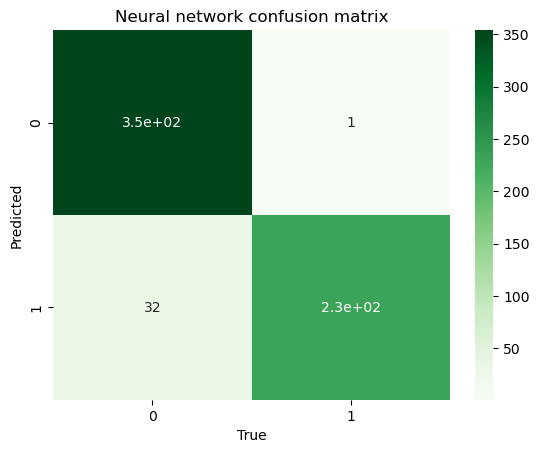

In [70]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Neural network confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_conf_matrix.pdf'), format='pdf')
plt.show()

In [71]:
net.model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                11600     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 16,802
Trainable params: 16,802
Non-trainable params: 0
_________________________________________________________________


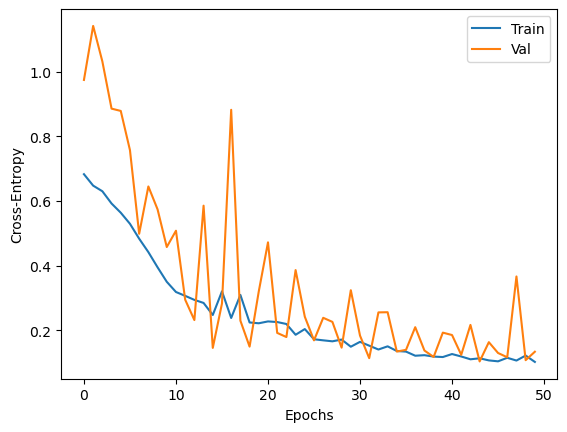

In [72]:
history = net.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_Cross_entropy_class.pdf'), format='pdf')
plt.show()

20/20 [==============================] - 0s 2ms/step


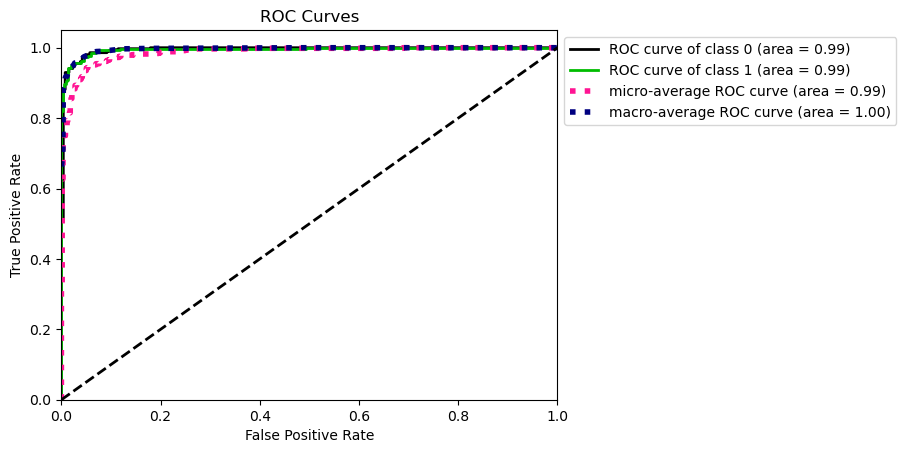

0.9946242339533383


In [73]:
y_test_pred_proba = net.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

# Ensemble methods

## Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [75]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-06-13 15:07:02,853] A new study created in memory with name: no-name-b8063f17-f991-4608-93a3-8eb089f6b8cd
[W 2023-06-13 15:07:03,667] Trial 5 failed with parameters: {'n_estimators': 540, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 9, 'bootstrap': False, 'criterion': 'gini'} because of the following error: ValueError('min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.disp

[W 2023-06-13 15:07:14,701] Trial 18 failed with value None.
[W 2023-06-13 15:07:15,135] Trial 19 failed with parameters: {'n_estimators': 1860, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini'} because of the following error: ValueError('min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\an

[W 2023-06-13 15:07:18,834] Trial 24 failed with value None.
[W 2023-06-13 15:07:19,177] Trial 25 failed with parameters: {'n_estimators': 1520, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901

[W 2023-06-13 15:07:20,168] Trial 28 failed with value None.
[W 2023-06-13 15:07:20,501] Trial 29 failed with parameters: {'n_estimators': 1490, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901

[W 2023-06-13 15:07:21,517] Trial 32 failed with value None.
[W 2023-06-13 15:07:21,851] Trial 33 failed with parameters: {'n_estimators': 1530, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901

[W 2023-06-13 15:07:22,867] Trial 36 failed with value None.
[W 2023-06-13 15:07:23,216] Trial 37 failed with parameters: {'n_estimators': 1550, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901

[W 2023-06-13 15:07:24,301] Trial 40 failed with value None.
[W 2023-06-13 15:07:24,636] Trial 41 failed with parameters: {'n_estimators': 1520, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901

[W 2023-06-13 15:07:25,651] Trial 44 failed with value None.
[W 2023-06-13 15:07:26,001] Trial 45 failed with parameters: {'n_estimators': 1530, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\emanu\anaconda3\lib\site-packages\joblib\parallel.py", line 901

[I 2023-06-13 15:07:31,118] Trial 14 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 1720, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 14 with value: 0.9230769230769231.
[I 2023-06-13 15:07:31,551] Trial 12 finished with value: 0.8717948717948718 and parameters: {'n_estimators': 2000, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 14 with value: 0.9230769230769231.
[I 2023-06-13 15:07:32,501] Trial 48 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 1540, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 14 with value: 0.9230769230769231.
[I 2023-06-13 15:07:32,667] Trial 21 finished with value: 0.8974358974358975 and parameters: {'n_estimators

In [76]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(X_res_t, y_res_t)

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 1720, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 1, 'bootstrap': False, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       355
           1       0.99      0.89      0.94       262

    accuracy                           0.95       617
   macro avg       0.96      0.94      0.95       617
weighted avg       0.95      0.95      0.95       617

Accuracy 0.9497568881685575
F1-score [0.95782313 0.93787575]


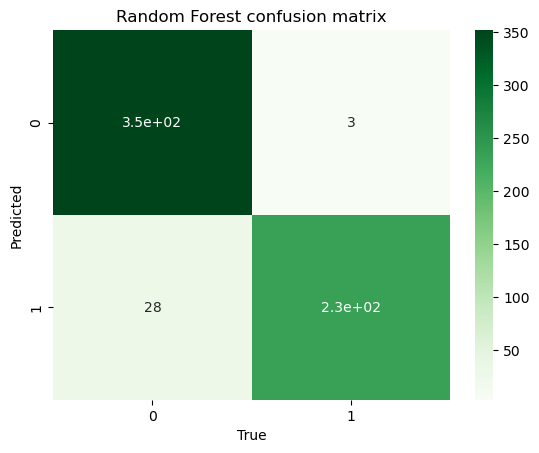

In [77]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Random Forest confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_conf_matrix.pdf'), format='pdf')
plt.show()

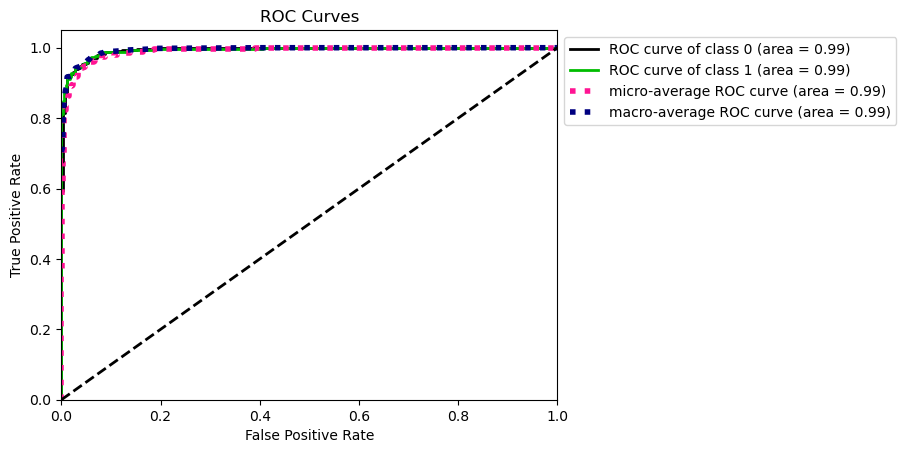

0.9932695409095796


In [78]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = rf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

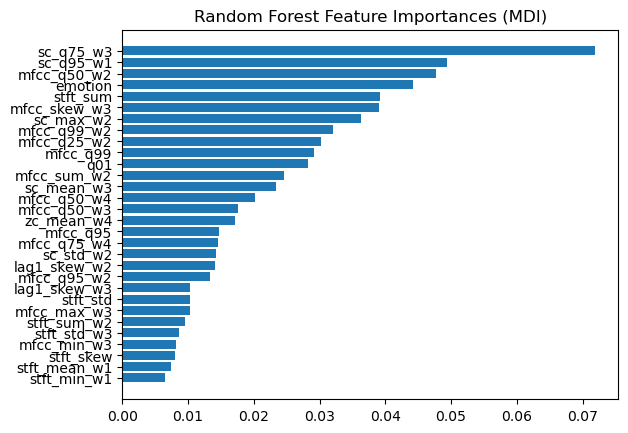

In [79]:
nbr_features = X_res_t.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_importance.pdf'), format='pdf')
plt.show()

In [80]:
from sklearn.inspection import permutation_importance

In [81]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

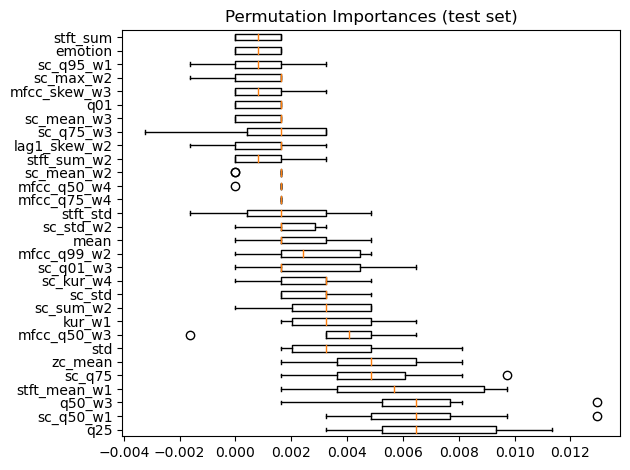

In [82]:
sorted_idx = result.importances_mean.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [83]:
from sklearn.tree import plot_tree

In [84]:
rf.estimators_[0]

DecisionTreeClassifier(max_depth=60, max_features='sqrt', min_samples_split=15,
                       random_state=706790325)

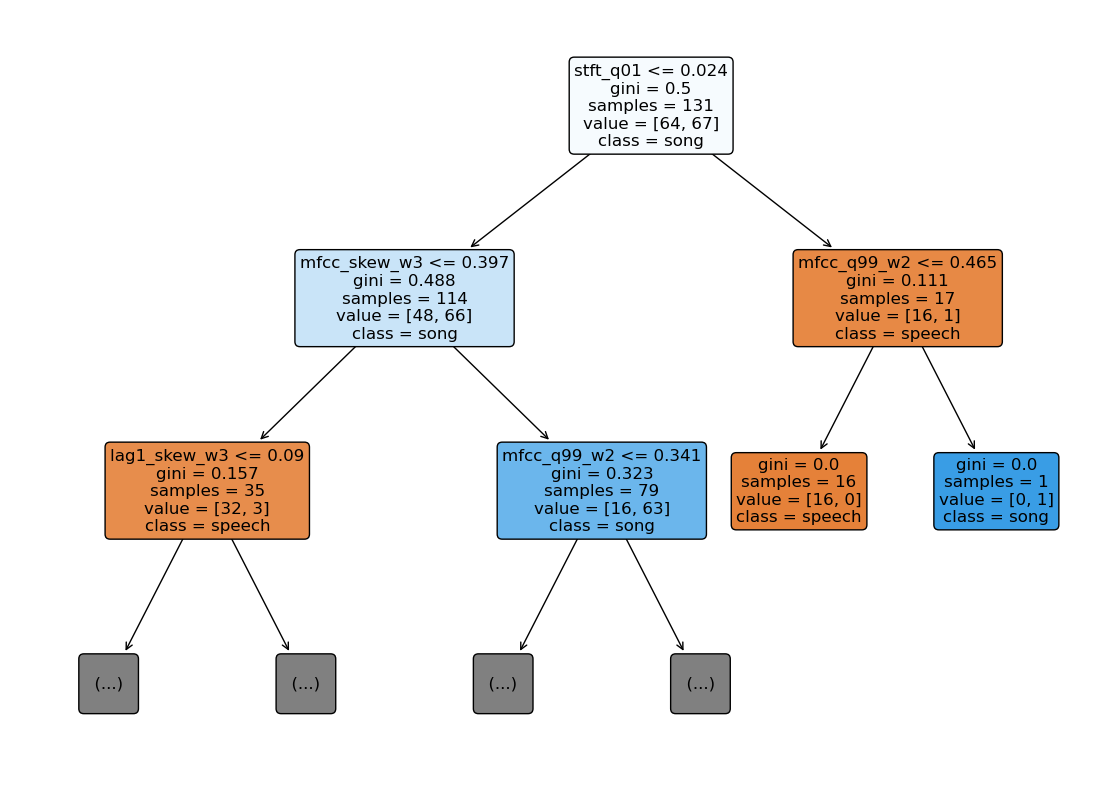

In [85]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_trees.pdf'), format='pdf')
plt.show()

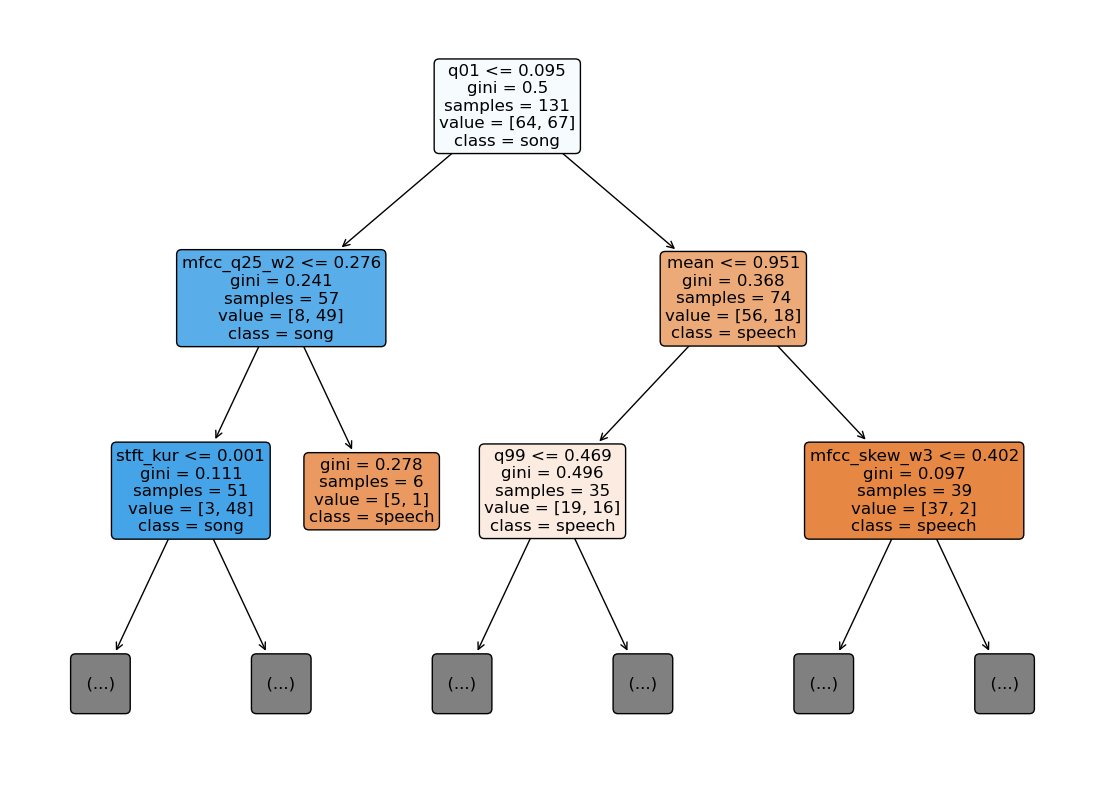

In [86]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [87]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [88]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 100, n_jobs = -1, catch=(ValueError,))

[I 2023-06-13 15:10:59,743] A new study created in memory with name: no-name-2e9f55f5-ee88-4c49-ab65-45336f4198f8
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  war

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-13 15:10:59,826] Trial 8 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-13 15:10:59,831] Trial 11 failed with parameters: {'n_estimators': 1, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 4, 'learning_rate': 0.08492219386247245, 'criterion': 'friedman_mse', 'subsample': 0.9568626954877588, 'loss': 'deviance'} because of the following error: ValueError('max_depth must be greater than zero. ').
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-13 15:10:59,901] Trial 15 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-13 15:10:59,926] Trial 17 failed with parameters: {'n_estimators': 18, 'max_depth': 30, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 3, 'learning_rate': 0.24544259734529034, 'criterion': 'friedman_mse', 'subsample': 0.5048287849252525, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_o

[W 2023-06-13 15:11:00,336] Trial 20 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[I 2023-06-13 15:11:00,577] Trial 9 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 8, 'max_depth': 10, 'max_featu

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[I 2023-06-13 15:11:00,835] Trial 18 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 18, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 5, 'learning_rate': 0.19673436353303866, 'criterion': 'friedman_mse', 'subsample': 0.8431417708353

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-13 15:11:01,854] Trial 38 failed with parameters: {'n_estimators': 16, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 2, 'learning_rate': 0.27835075151169486, 'criterion': 'mae', 'subsample': 0.6221466172087603, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\s

[W 2023-06-13 15:11:02,075] Trial 42 failed with parameters: {'n_estimators': 17, 'max_depth': 90, 'max_features': 'log2', 'min_samples_split': 1, 'min_samples_leaf': 2, 'learning_rate': 0.28751561620766597, 'criterion': 'mae', 'subsample': 0.6302507149855393, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not supported. 
[

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-13 15:11:02,435] Trial 47 failed with parameters: {'n_estimators': 17, 'max_depth': 90, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 2, 'learning_rate': 0.28081738616443186, 'criterion': 'mae', 'subsample': 0.6158957702448706, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\si

[W 2023-06-13 15:11:02,610] Trial 52 failed with parameters: {'n_estimators': 15, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 3, 'learning_rate': 0.012764163708560289, 'criterion': 'mae', 'subsample': 0.618795750932574, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not supported. 


[W 2023-06-13 15:11:02,951] Trial 57 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-13 15:11:02,968] Trial 58 failed with parameters: {'n_estimators': 15, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 3, 'learning_rate': 0.010016875119752883, 'criterion': 'mae', 'subsample': 0.5091381489462992, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-13 15:11:03,352] Trial 63 failed with parameters: {'n_estimators': 15, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 3, 'learning_rate': 0.023046547522486333, 'criterion': 'mae', 'subsample': 0.5036739974111797, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  Fil

[W 2023-06-13 15:11:03,535] Trial 66 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
[W 2023-06-13 15:11:03,562] Trial 67 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-13 15:11:03,578] Trial 68 failed with value None.
[W 2023-06-13 15:11:03,603] Trial 69 failed with parameters: {'n_estimators': 2, 'max_depth': 70, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 2, 'learning_rate': 0.03063092137167371, 'criterion': 'mae', 'subsample': 0.62233925

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-13 15:11:04,001] Trial 76 failed with parameters: {'n_estimators': 14, 'max_depth': 70, 'ma

[W 2023-06-13 15:11:04,260] Trial 79 failed with parameters: {'n_estimators': 15, 'max_depth': 70, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 2, 'learning_rate': 0.08765311341277156, 'criterion': 'mae', 'subsample': 0.5066138439841669, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not supported. 


[W 2023-06-13 15:11:04,485] Trial 83 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-13 15:11:04,506] Trial 84 failed with value None.
[W 2023-06-13 15:11:04,543] Trial 86 failed with parameters: {'n_estimators': 3, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 3, 'learning_rate': 0.09593980652706778, 'criterion': 'mae', 'subsample': 0.5068214452444718, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Use

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-13 15:11:04,794] Trial 90 failed with value None.
[W 2023-06-13 15:11:04,818] Trial 91 failed with parameters: {'n_estimators': 4, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 3, 'learning_rate': 0.09754702178287758, 'criterion': 'mae', 'subsample': 0.5151978919753828, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_29392\3961920590.py", l

[W 2023-06-13 15:11:04,984] Trial 96 failed with value None.
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
[W 2023-06-13 15:11:05,006] Trial 98 failed with parameters: {'n_estimators': 3, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 3, 'learning_rate': 0.09545267613269257, 'criterion': 'mae', 'subsample': 0.5089296010680591, 'loss': 'log_loss'} because of the following error: ValueError("Loss 'log_loss' not supported. ").
Traceback (mo

In [89]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(X_res_t, y_res_t)

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 9, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 10, 'learning_rate': 0.21118100274378954, 'criterion': 'friedman_mse', 'subsample': 0.5423586949499253, 'loss': 'deviance'}
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       355
           1       0.95      0.89      0.92       262

    accuracy                           0.93       617
   macro avg       0.93      0.93      0.93       617
weighted avg       0.93      0.93      0.93       617

Accuracy 0.9319286871961102
F1-score [0.94214876 0.91732283]


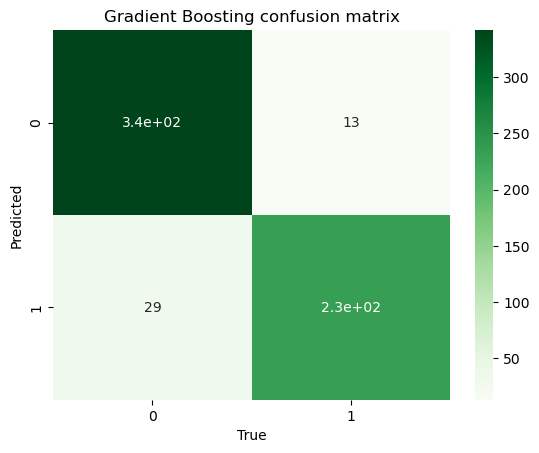

In [90]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Gradient Boosting confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'GB_conf_matrix.pdf'), format='pdf')
plt.show()

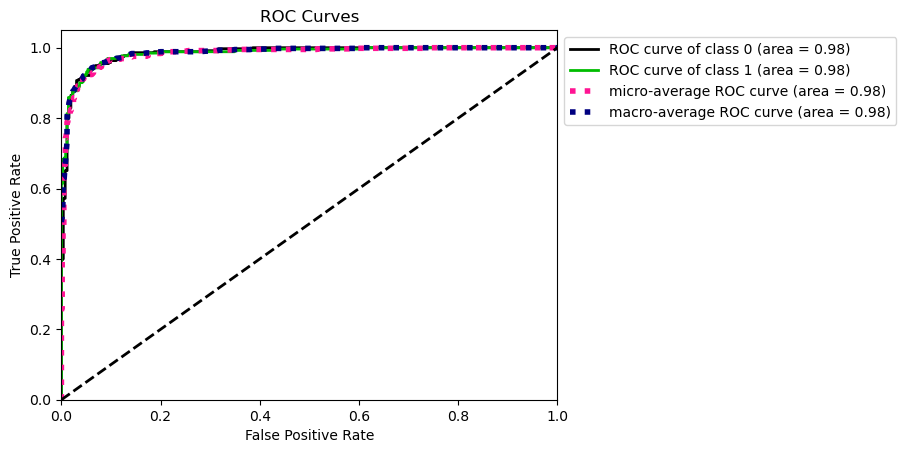

0.9841522416944415


In [91]:
y_test_pred_proba = gb.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'GB_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))